# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [2]:
os.listdir("./")

['modeling_covics_eindhoven.ipynb',
 'figs',
 'code',
 'nls_R_attempt_all_regions.R',
 '.gitmodules',
 'COVID-19',
 '.gitignore',
 'nls_R_attempt.R',
 '.ipynb_checkpoints',
 'modeling_covics.ipynb',
 'data']

In [3]:
# Load datasets

covid_confirmed = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [4]:
# Load the start of these datasets
#covid_confirmed.head()
#covid_deaths.head()
#covid_recovered.head()

In [5]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
# Test this code with covid_confirmed = covid_confirmed.drop(['Lat'], axis=1)
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)}')

Total number of days in database: 71


In [6]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [7]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)


In [8]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [9]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 
# Fit - but not working
#days2 = np.array([i for i in range(len(dates))]).reshape(1,-1)
#popt, pcov = curve_fit(func, days.ravel(),  total_confirmed.ravel())
#plt.plot(days, total_confirmed, 'b-', days, func(days, *popt), 'g--')
popt = [total_confirmed_global[0],0.1075]

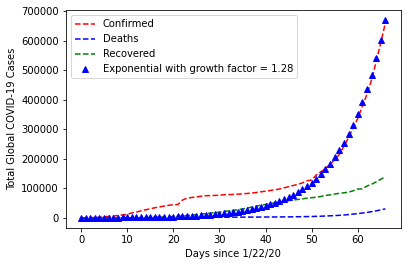

In [10]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [11]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [12]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [13]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [14]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [15]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [16]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 121478 cases
Italy: 92472 cases
China: 81999 cases
Spain: 73235 cases
Germany: 57695 cases
France: 38105 cases
Iran: 35408 cases
United Kingdom: 17312 cases
Switzerland: 14076 cases
Netherlands: 9819 cases


In [17]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [18]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

Confirmed cases by Province/State
Australian Capital Territory: 71 cases
New South Wales: 1617 cases
Northern Territory: 15 cases
Queensland: 625 cases
South Australia: 287 cases
Tasmania: 62 cases
Victoria: 685 cases
Western Australia: 278 cases
Anhui: 990 cases
Beijing: 573 cases


In [19]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

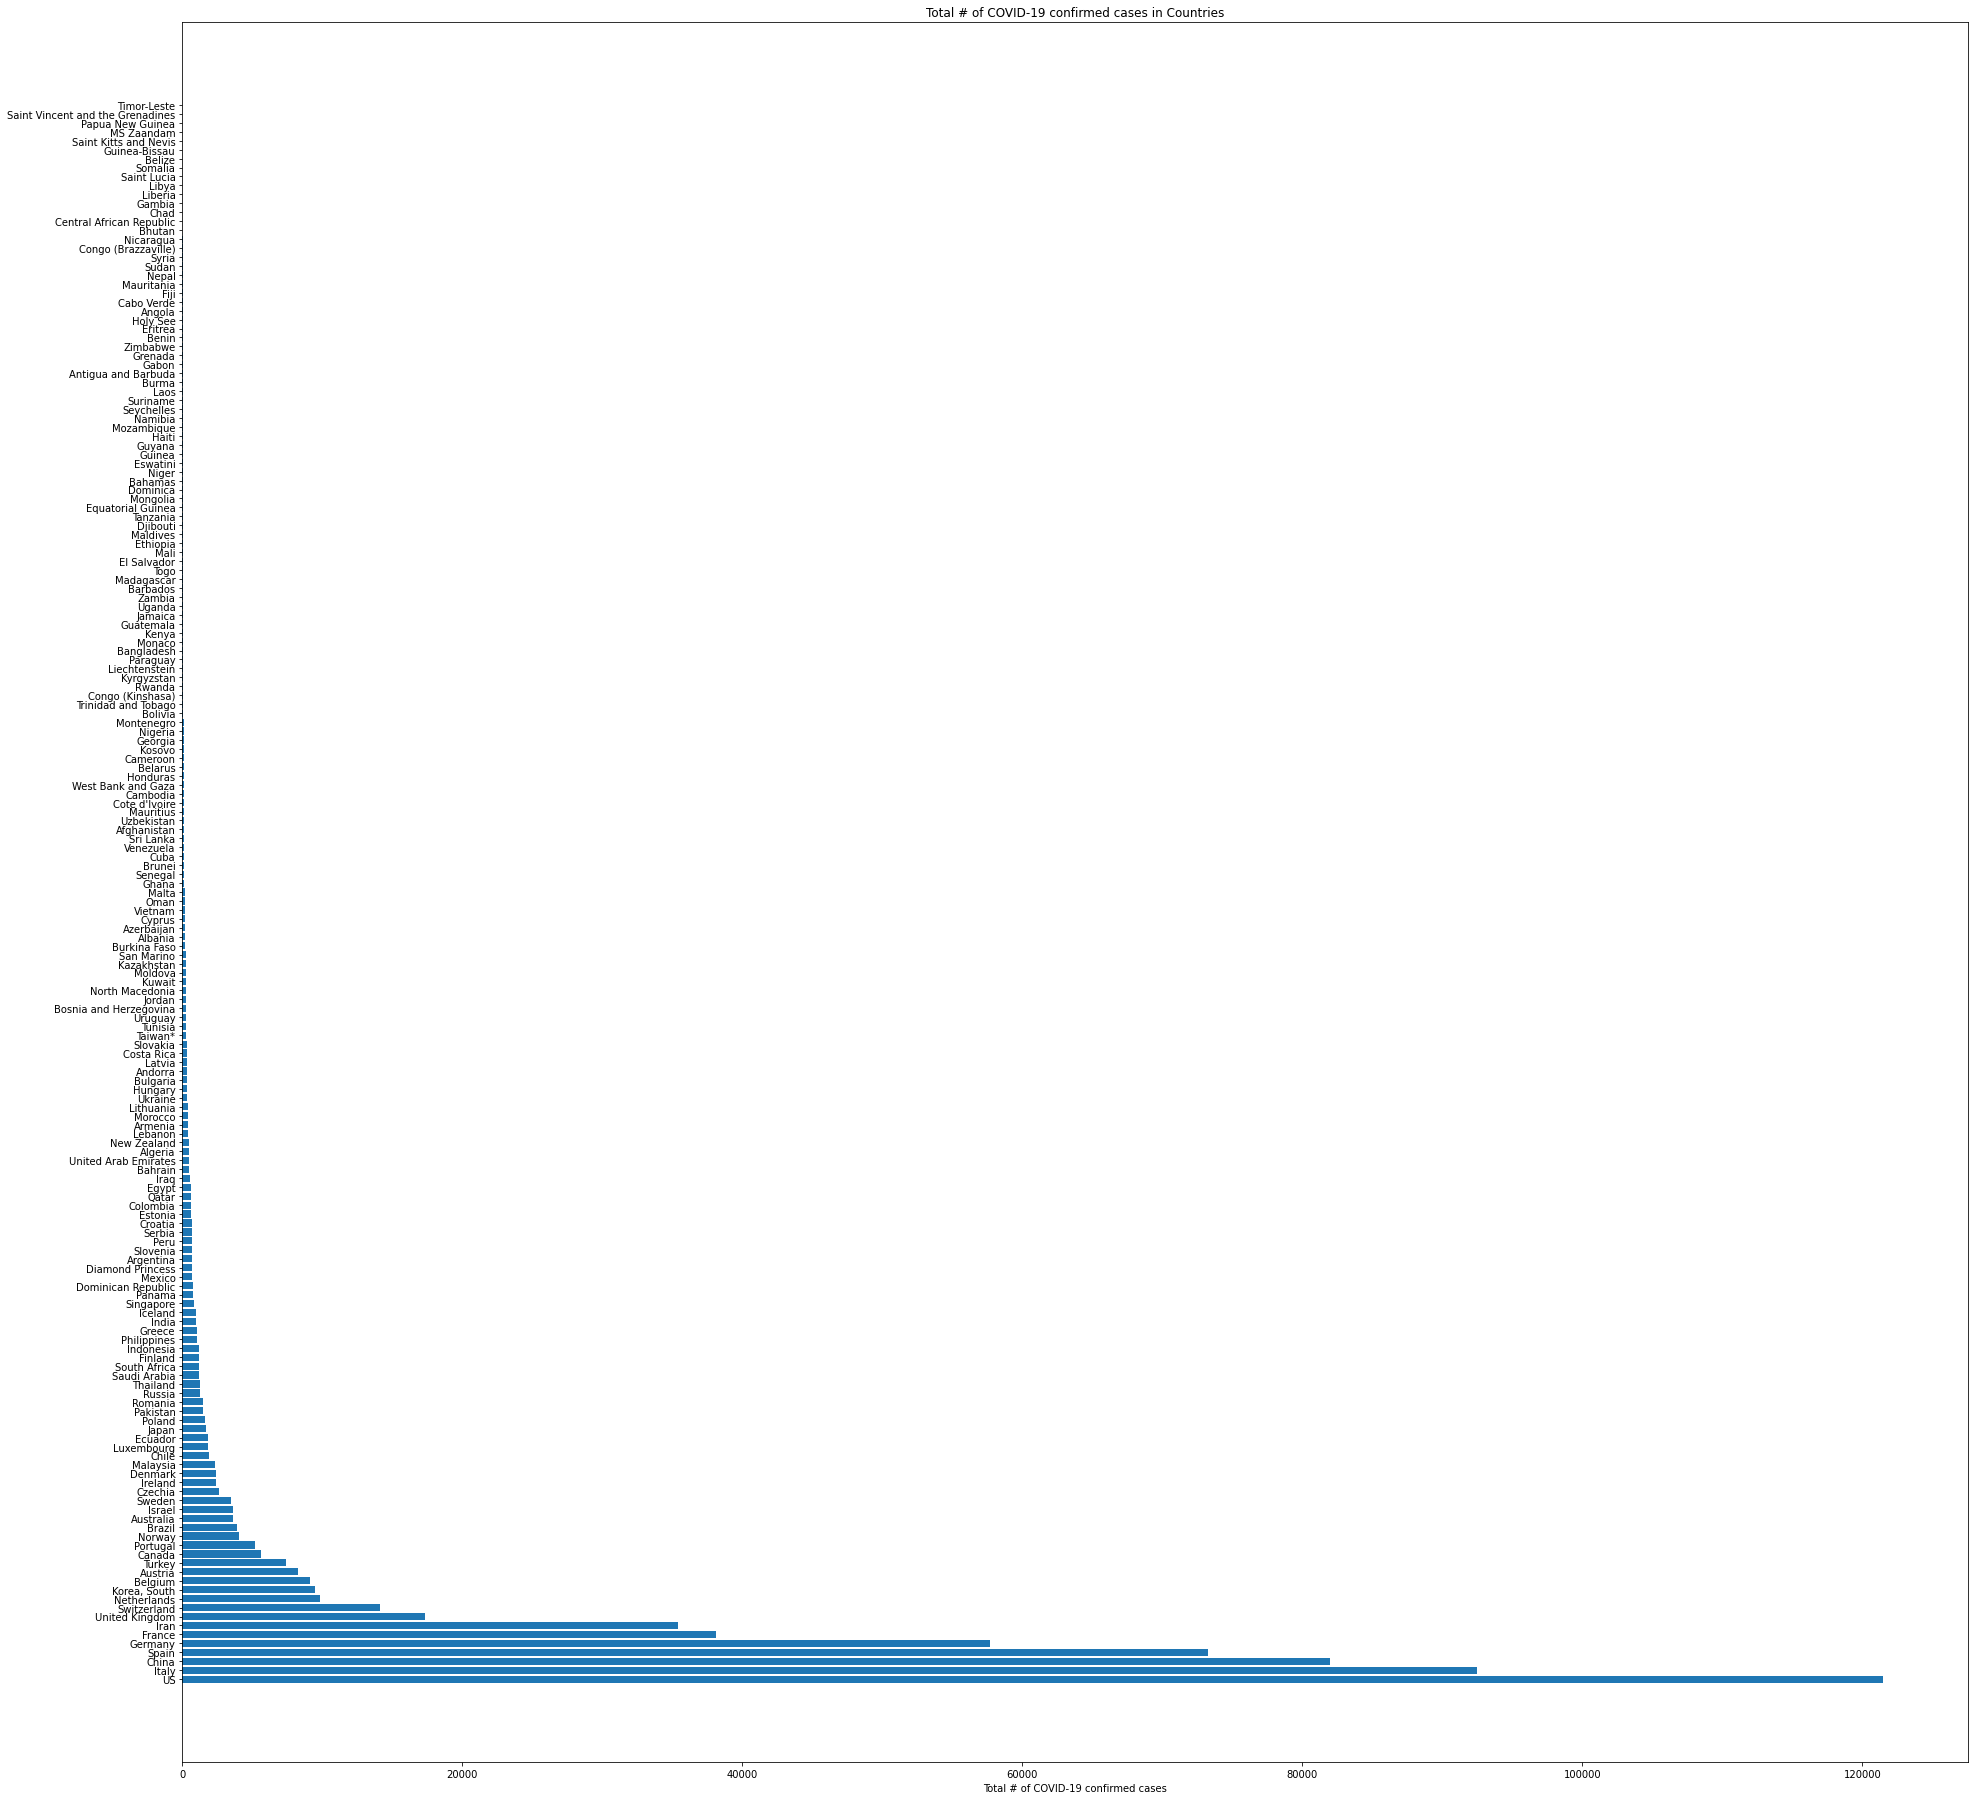

In [20]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

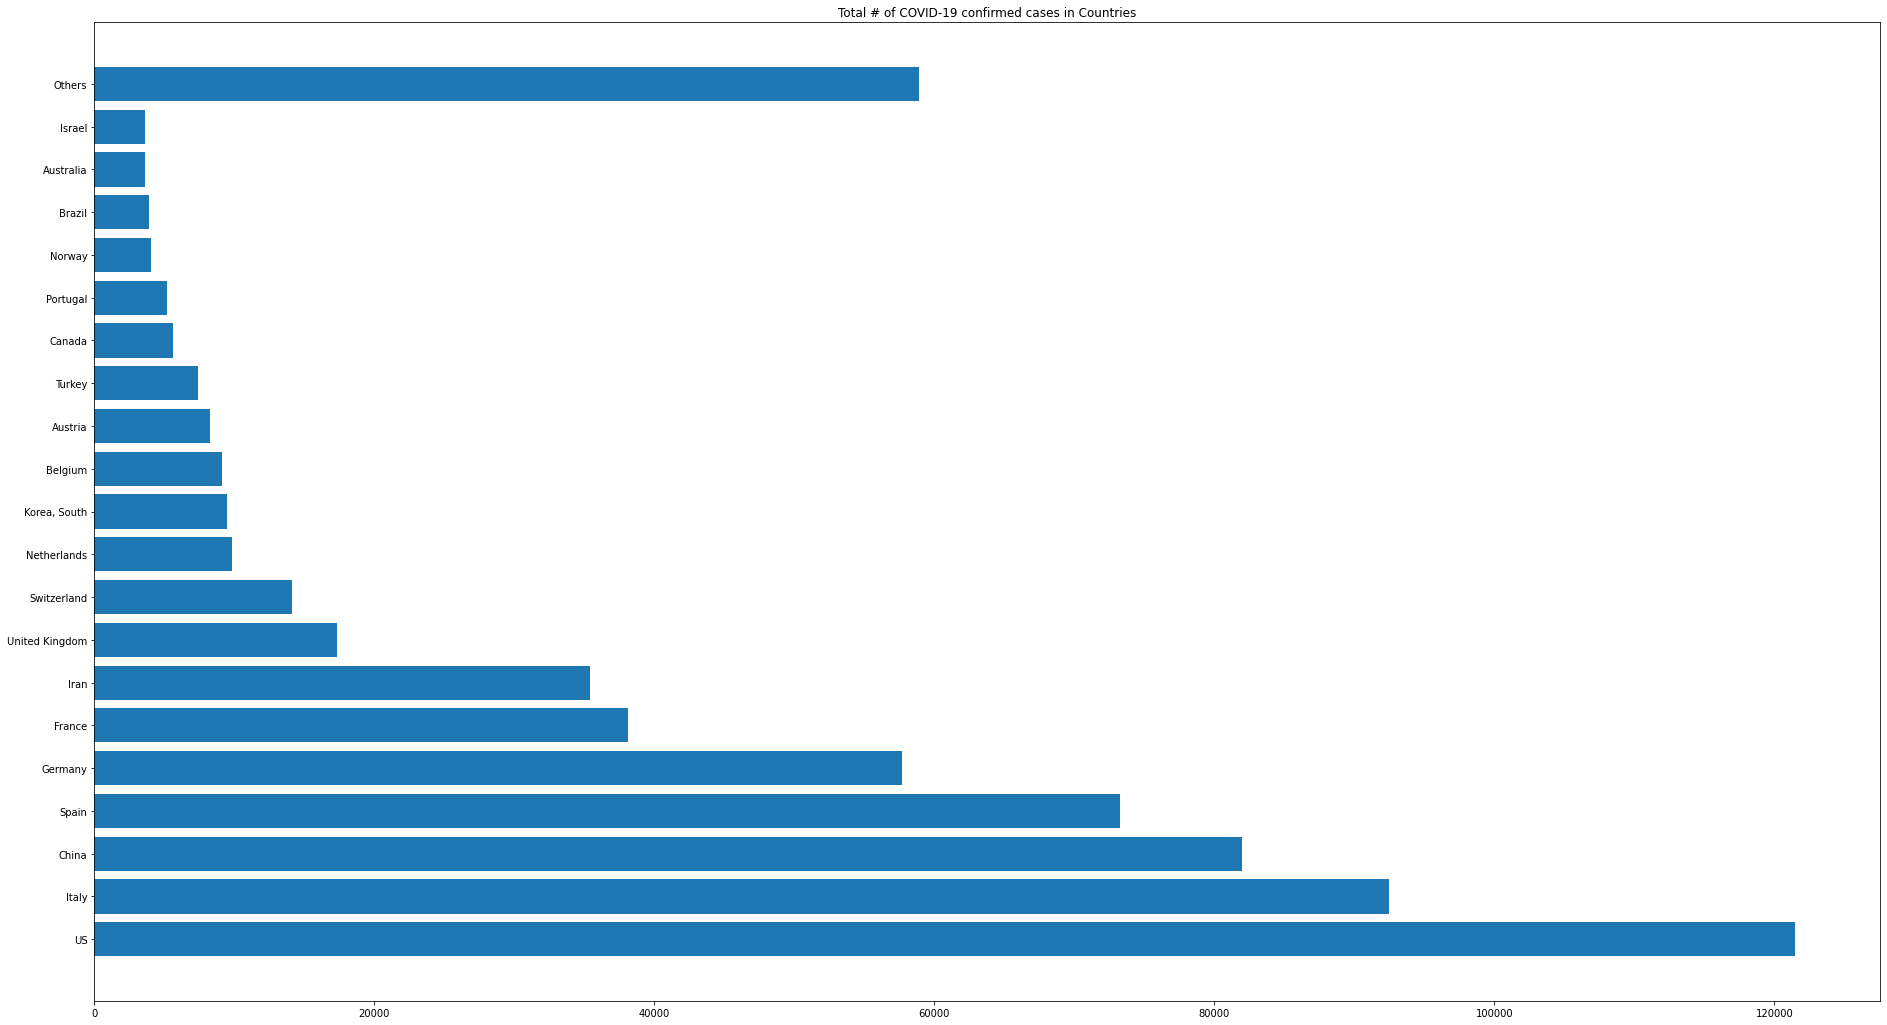

In [21]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

## Fit Hopkins data ## 

In [22]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 121478
	Confirmed cases on 3/21/20 	 25489
	Ratio: 4.77
	Weekly increase: 376.6 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.9960704451922813
	Doubling Time (represents overall growth):  3.03 (± 0.1 ) days


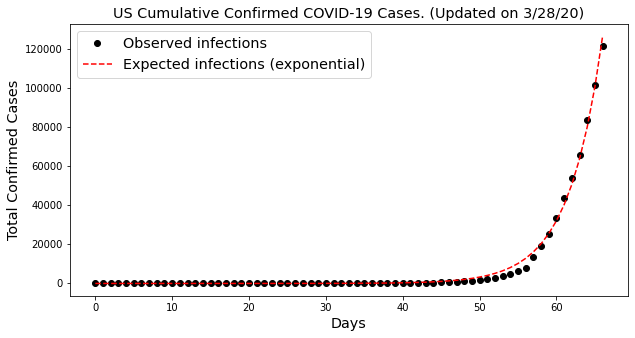



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 92472
	Confirmed cases on 3/21/20 	 53578
	Ratio: 1.73
	Weekly increase: 72.6 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9995732505421895
	Doubling Time (during middle of growth):  7.39 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9822743660577621
	Doubling Time (represents overall growth):  5.68 (± 0.44 ) days


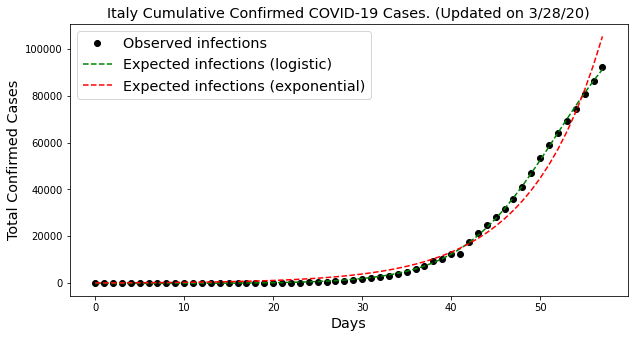



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 81999
	Confirmed cases on 3/21/20 	 81305
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 570.9 days

** Based on Logistic Fit**

	R^2: 0.9956956500454023
	Doubling Time (during middle of growth):  6.51 (± 0.49 ) days


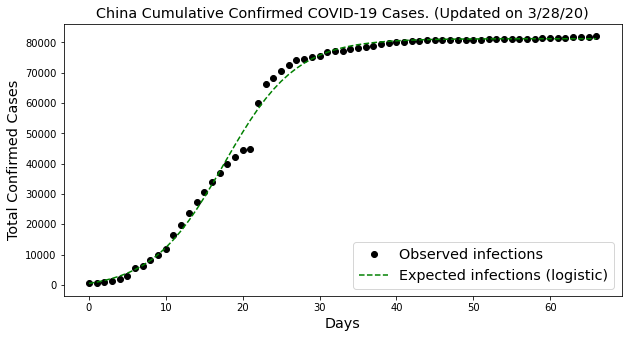



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 73235
	Confirmed cases on 3/21/20 	 25374
	Ratio: 2.89
	Weekly increase: 188.6 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9990232631098044
	Doubling Time (during middle of growth):  6.29 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.9955461602313334
	Doubling Time (represents overall growth):  4.13 (± 0.15 ) days


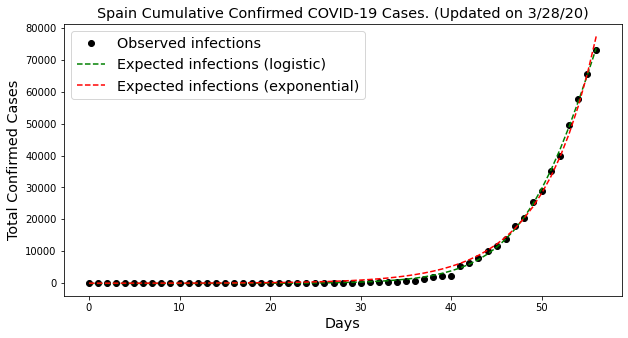



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 57695
	Confirmed cases on 3/21/20 	 22213
	Ratio: 2.6
	Weekly increase: 159.7 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9979502193618535
	Doubling Time (during middle of growth):  6.33 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9935179667217177
	Doubling Time (represents overall growth):  4.35 (± 0.19 ) days


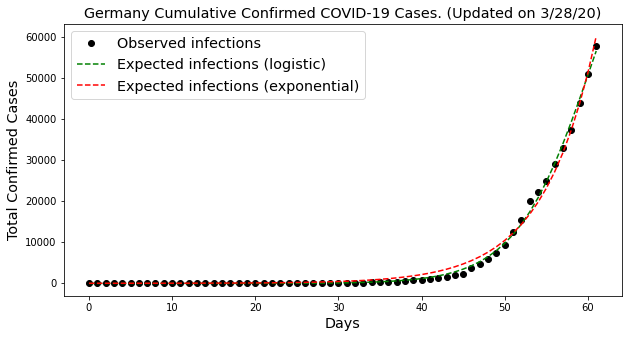



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 38105
	Confirmed cases on 3/21/20 	 14463
	Ratio: 2.63
	Weekly increase: 163.5 %
	Daily increase: 14.8 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Exponential Fit **

	R^2: 0.9965517929829968
	Doubling Time (represents overall growth):  4.66 (± 0.14 ) days


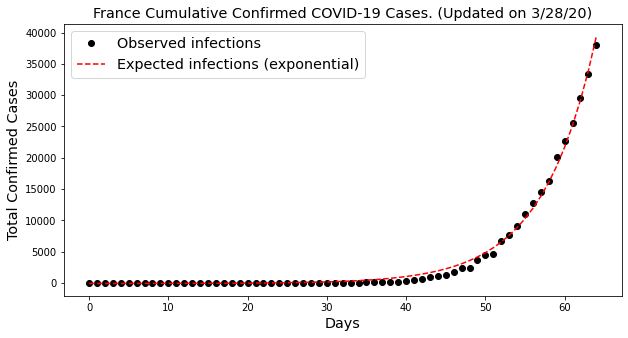



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 35408
	Confirmed cases on 3/21/20 	 20610
	Ratio: 1.72
	Weekly increase: 71.8 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9940655475441372
	Doubling Time (during middle of growth):  16.11 (± 4.9 ) days


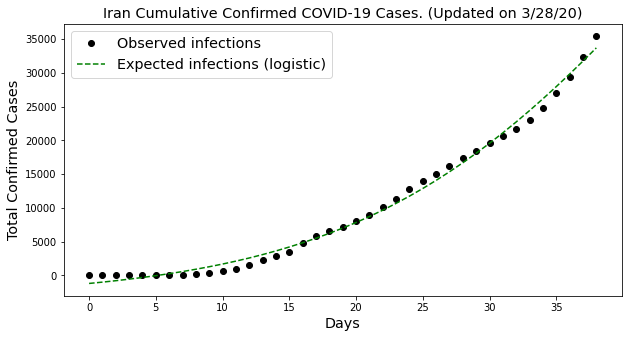



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 17312
	Confirmed cases on 3/21/20 	 5067
	Ratio: 3.42
	Weekly increase: 241.7 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.9986402504097032
	Doubling Time (represents overall growth):  3.62 (± 0.07 ) days


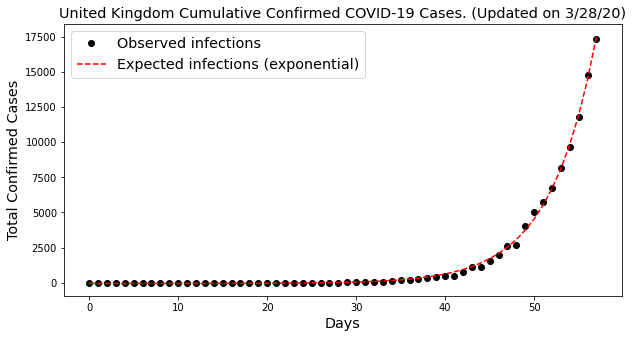



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 14076
	Confirmed cases on 3/21/20 	 6575
	Ratio: 2.14
	Weekly increase: 114.1 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9987917389173533
	Doubling Time (during middle of growth):  5.09 (± 0.33 ) days

** Based on Exponential Fit **

	R^2: 0.9749942071660763
	Doubling Time (represents overall growth):  4.36 (± 0.59 ) days


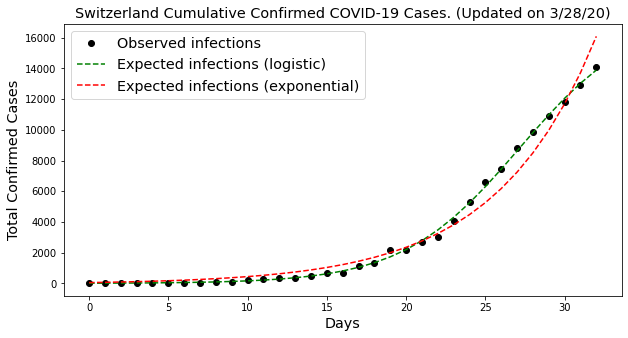



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 9819
	Confirmed cases on 3/21/20 	 3640
	Ratio: 2.7
	Weekly increase: 169.8 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9996197833868619
	Doubling Time (during middle of growth):  7.47 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.9975910347756053
	Doubling Time (represents overall growth):  4.49 (± 0.2 ) days


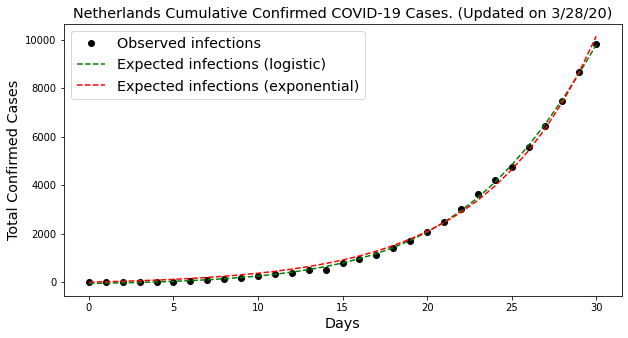



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 9478
	Confirmed cases on 3/21/20 	 8799
	Ratio: 1.08
	Weekly increase: 7.7 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 65.3 days

** Based on Logistic Fit**

	R^2: 0.9966218942020199
	Doubling Time (during middle of growth):  4.92 (± 0.35 ) days


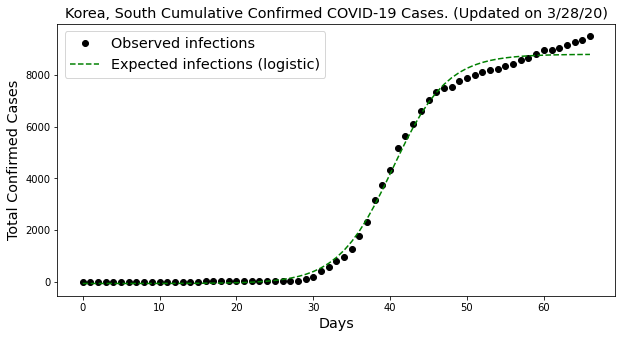



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 9134
	Confirmed cases on 3/21/20 	 2815
	Ratio: 3.24
	Weekly increase: 224.5 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9978213659072621
	Doubling Time (during middle of growth):  7.86 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997821365984304
	Doubling Time (represents overall growth):  3.93 (± 0.11 ) days


/Users/othmanerifki/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


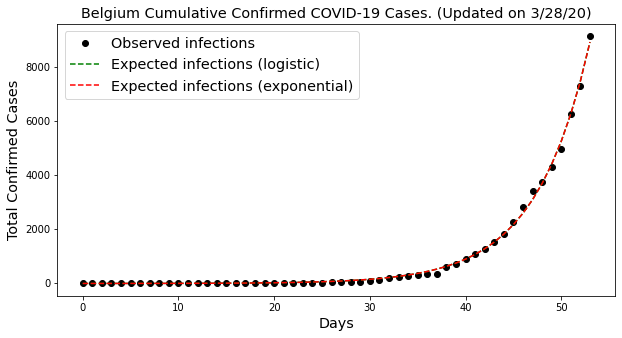



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 8271
	Confirmed cases on 3/21/20 	 2814
	Ratio: 2.94
	Weekly increase: 193.9 %
	Daily increase: 16.7 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.9986236351274853
	Doubling Time (during middle of growth):  5.46 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9905763671829443
	Doubling Time (represents overall growth):  4.34 (± 0.36 ) days


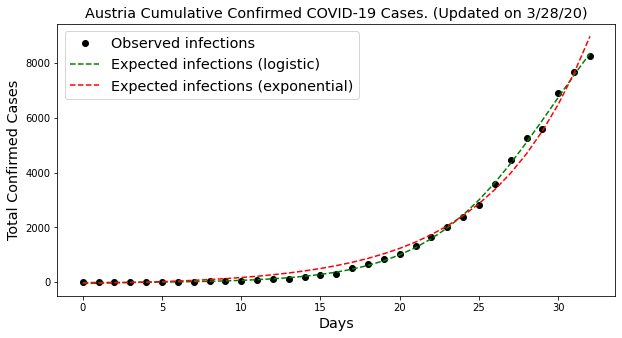



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 7402
	Confirmed cases on 3/21/20 	 670
	Ratio: 11.05
	Weekly increase: 1004.8 %
	Daily increase: 40.9 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.9949898097007809
	Doubling Time (during middle of growth):  4.06 (± 1.18 ) days

** Based on Exponential Fit **

	R^2: 0.9949801985875648
	Doubling Time (represents overall growth):  2.08 (± 0.17 ) days


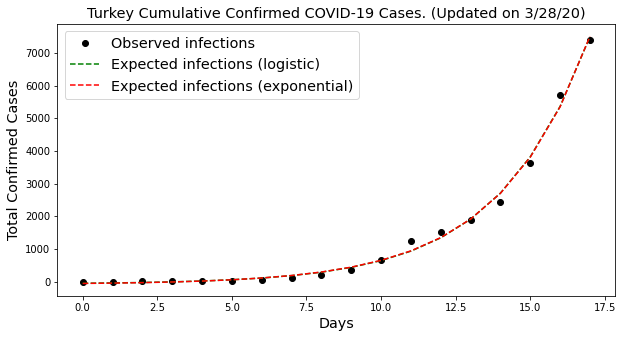



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 5576
	Confirmed cases on 3/21/20 	 1277
	Ratio: 4.37
	Weekly increase: 336.6 %
	Daily increase: 23.4 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.9960707890616183
	Doubling Time (represents overall growth):  3.3 (± 0.11 ) days


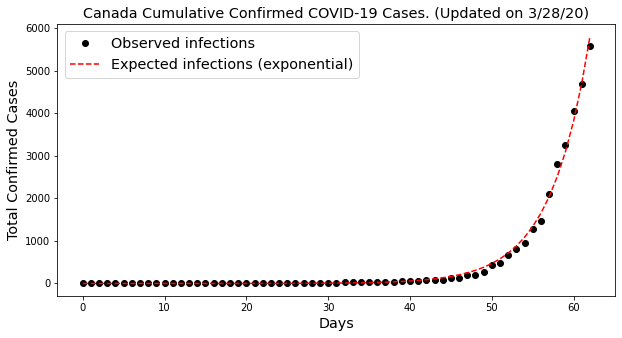



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 5170
	Confirmed cases on 3/21/20 	 1280
	Ratio: 4.04
	Weekly increase: 303.9 %
	Daily increase: 22.1 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.998886539423328
	Doubling Time (during middle of growth):  5.47 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9973972823589867
	Doubling Time (represents overall growth):  3.53 (± 0.17 ) days


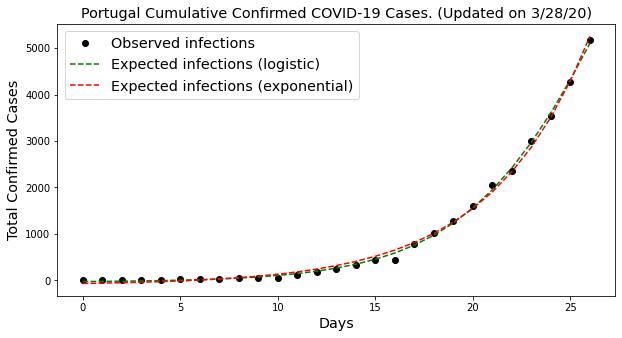



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 4015
	Confirmed cases on 3/21/20 	 2118
	Ratio: 1.9
	Weekly increase: 89.6 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9946386282834033
	Doubling Time (during middle of growth):  10.63 (± 2.59 ) days

** Based on Exponential Fit **

	R^2: 0.9705970446324859
	Doubling Time (represents overall growth):  5.67 (± 0.97 ) days


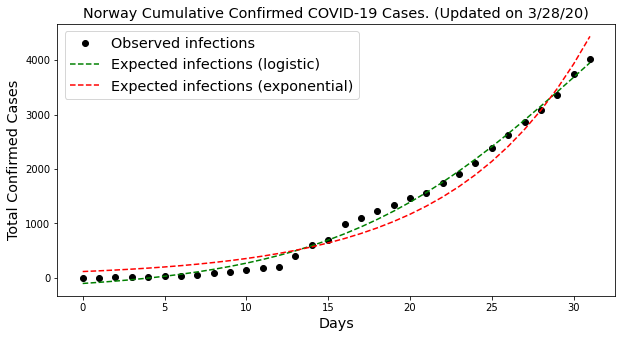



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 3904
	Confirmed cases on 3/21/20 	 1021
	Ratio: 3.82
	Weekly increase: 282.4 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9980098377686218
	Doubling Time (during middle of growth):  4.04 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9862412955246653
	Doubling Time (represents overall growth):  3.86 (± 0.38 ) days


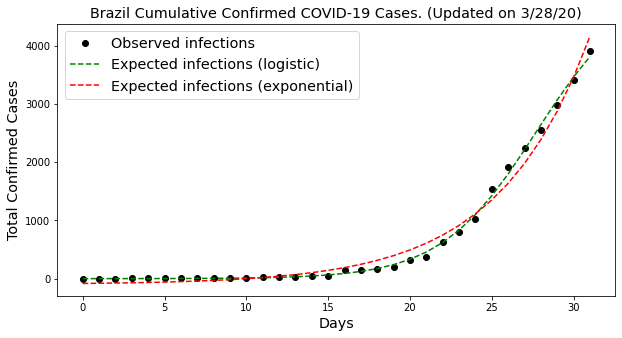



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 3640
	Confirmed cases on 3/21/20 	 1071
	Ratio: 3.4
	Weekly increase: 239.9 %
	Daily increase: 19.1 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.9939589985324981
	Doubling Time (represents overall growth):  3.92 (± 0.16 ) days


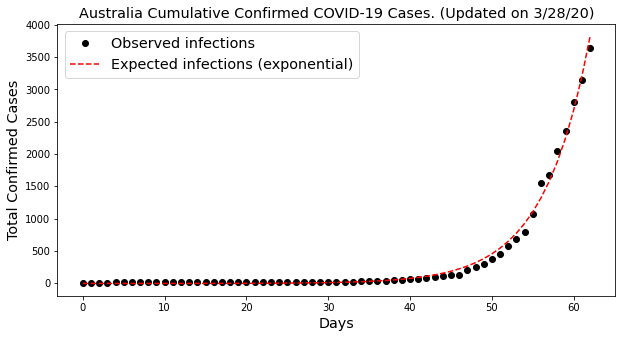



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 3619
	Confirmed cases on 3/21/20 	 712
	Ratio: 5.08
	Weekly increase: 408.3 %
	Daily increase: 26.1 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.9895536529858814
	Doubling Time (during middle of growth):  3.94 (± 0.76 ) days

** Based on Exponential Fit **

	R^2: 0.9852873463634045
	Doubling Time (represents overall growth):  3.01 (± 0.26 ) days


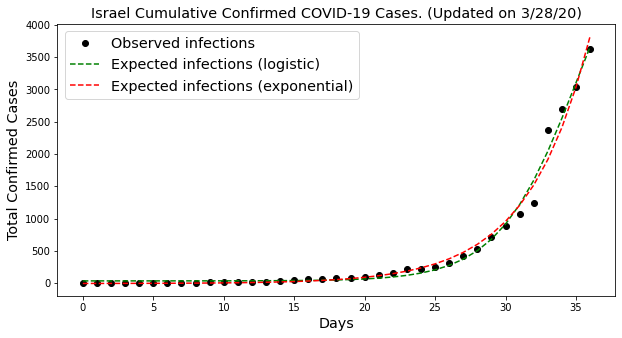



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 3447
	Confirmed cases on 3/21/20 	 1763
	Ratio: 1.96
	Weekly increase: 95.5 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9933011021564024
	Doubling Time (during middle of growth):  9.02 (± 1.12 ) days

** Based on Exponential Fit **

	R^2: 0.9884611454886475
	Doubling Time (represents overall growth):  6.72 (± 0.43 ) days


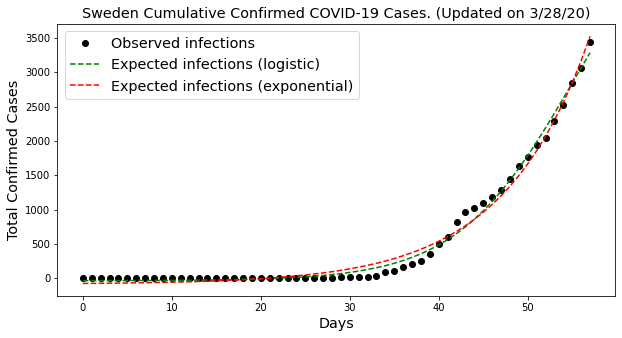



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 2631
	Confirmed cases on 3/21/20 	 995
	Ratio: 2.64
	Weekly increase: 164.4 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.996439939060244
	Doubling Time (during middle of growth):  7.35 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.9954193548853227
	Doubling Time (represents overall growth):  4.68 (± 0.32 ) days


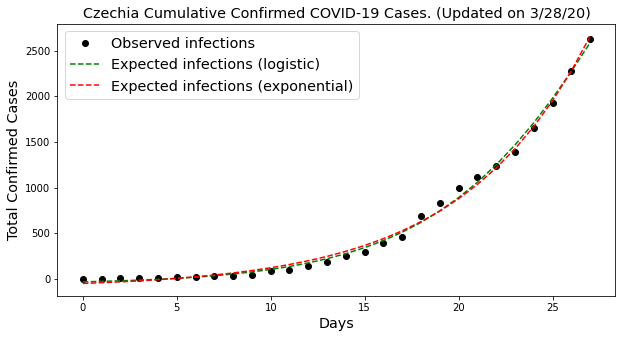



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 2415
	Confirmed cases on 3/21/20 	 785
	Ratio: 3.08
	Weekly increase: 207.6 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9974129514761738
	Doubling Time (during middle of growth):  5.27 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9924142617841051
	Doubling Time (represents overall growth):  4.19 (± 0.34 ) days


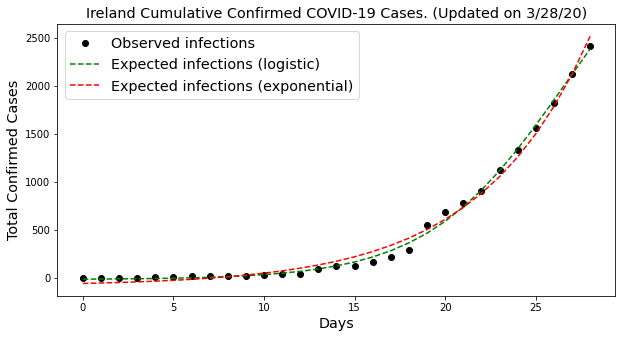



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 2366
	Confirmed cases on 3/21/20 	 1420
	Ratio: 1.67
	Weekly increase: 66.6 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9829790095710763
	Doubling Time (during middle of growth):  9.76 (± 3.88 ) days


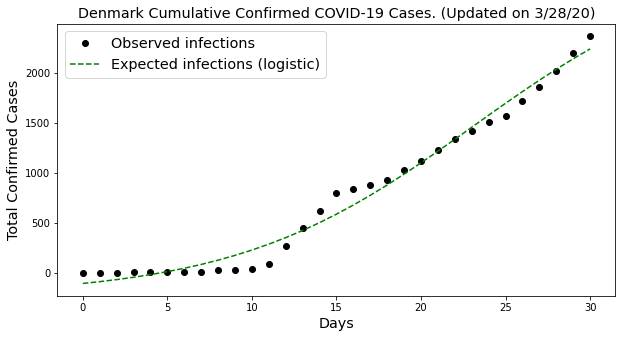



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 2320
	Confirmed cases on 3/21/20 	 1183
	Ratio: 1.96
	Weekly increase: 96.1 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9977869337304519
	Doubling Time (during middle of growth):  5.86 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.984340473443969
	Doubling Time (represents overall growth):  5.52 (± 0.37 ) days


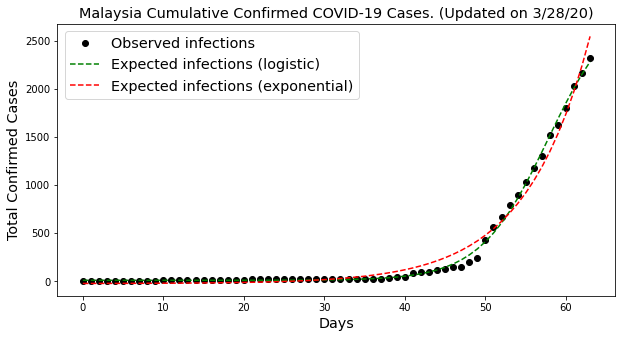



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1909
	Confirmed cases on 3/21/20 	 537
	Ratio: 3.55
	Weekly increase: 255.5 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.9978581082838642
	Doubling Time (during middle of growth):  5.81 (± 0.77 ) days

** Based on Exponential Fit **

	R^2: 0.9965814624150172
	Doubling Time (represents overall growth):  3.75 (± 0.22 ) days


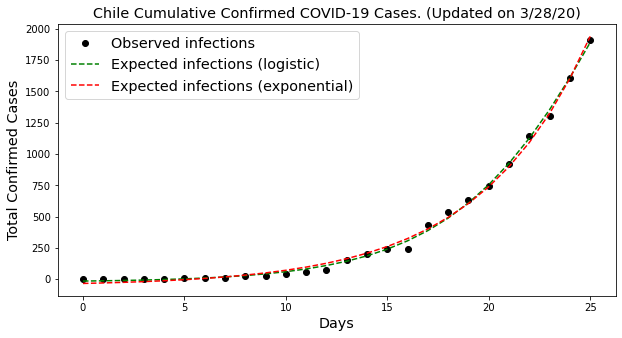



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1831
	Confirmed cases on 3/21/20 	 670
	Ratio: 2.73
	Weekly increase: 173.3 %
	Daily increase: 15.4 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9969667801908505
	Doubling Time (during middle of growth):  3.98 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.9805992551923435
	Doubling Time (represents overall growth):  4.31 (± 0.57 ) days


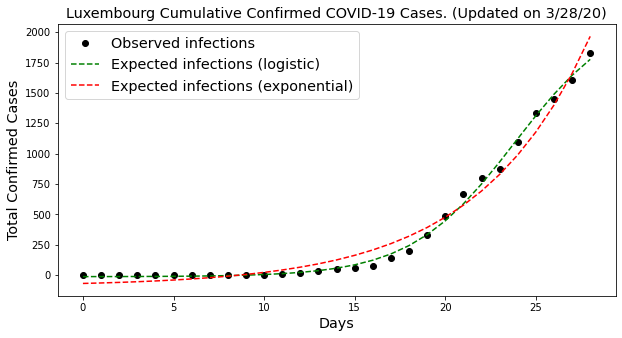



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1823
	Confirmed cases on 3/21/20 	 506
	Ratio: 3.6
	Weekly increase: 260.3 %
	Daily increase: 20.1 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.9926007079384436
	Doubling Time (during middle of growth):  3.28 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.9707255237956325
	Doubling Time (represents overall growth):  3.92 (± 0.64 ) days


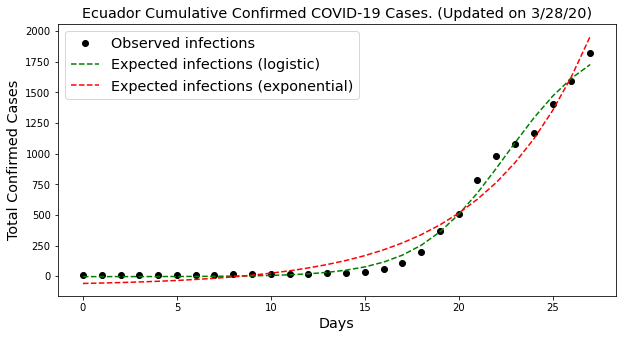



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1693
	Confirmed cases on 3/21/20 	 1007
	Ratio: 1.68
	Weekly increase: 68.1 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9936749437587915
	Doubling Time (during middle of growth):  17.91 (± 2.64 ) days

** Based on Exponential Fit **

	R^2: 0.9923626056320384
	Doubling Time (represents overall growth):  12.26 (± 0.71 ) days


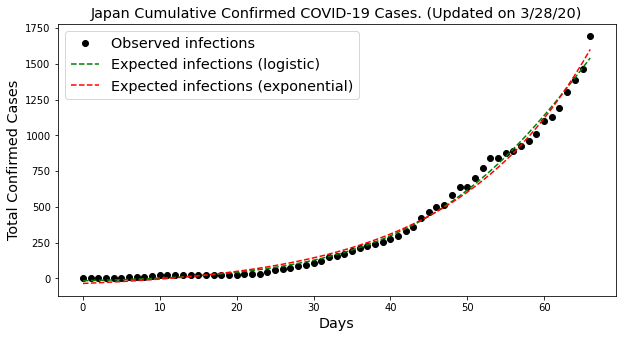



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1638
	Confirmed cases on 3/21/20 	 536
	Ratio: 3.06
	Weekly increase: 205.6 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9992788243849668
	Doubling Time (during middle of growth):  6.36 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9975213159804748
	Doubling Time (represents overall growth):  4.52 (± 0.25 ) days


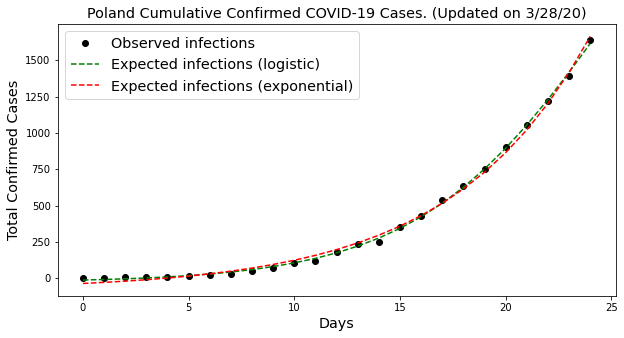



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1495
	Confirmed cases on 3/21/20 	 730
	Ratio: 2.05
	Weekly increase: 104.8 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9931838910735112
	Doubling Time (during middle of growth):  4.37 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9743761684287616
	Doubling Time (represents overall growth):  5.05 (± 0.75 ) days


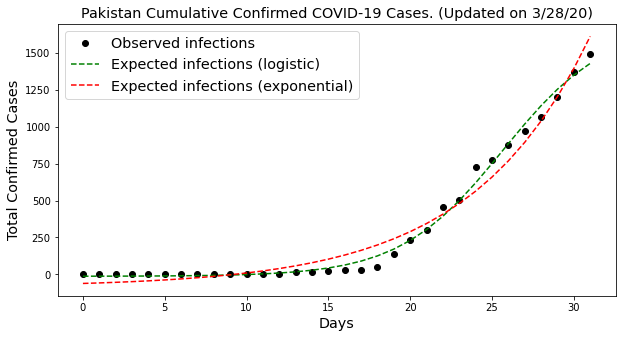



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1452
	Confirmed cases on 3/21/20 	 367
	Ratio: 3.96
	Weekly increase: 295.6 %
	Daily increase: 21.7 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9963161723741155
	Doubling Time (during middle of growth):  6.34 (± 0.95 ) days

** Based on Exponential Fit **

	R^2: 0.9956237404478696
	Doubling Time (represents overall growth):  3.8 (± 0.21 ) days


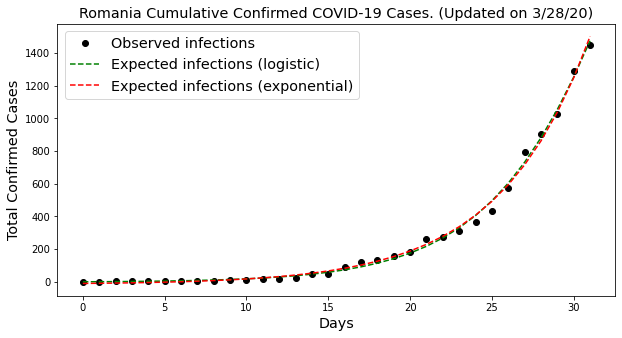



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1264
	Confirmed cases on 3/21/20 	 306
	Ratio: 4.13
	Weekly increase: 313.1 %
	Daily increase: 22.5 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9987493293769423
	Doubling Time (represents overall growth):  3.24 (± 0.06 ) days


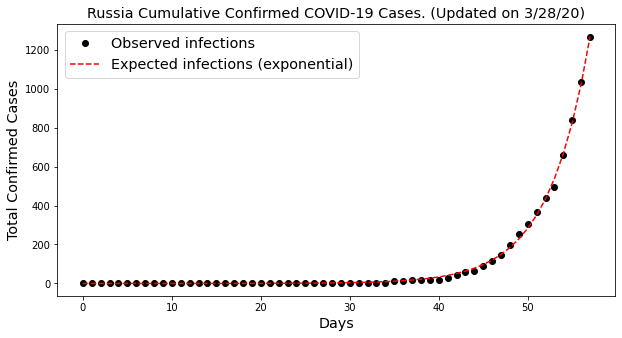



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1245
	Confirmed cases on 3/21/20 	 411
	Ratio: 3.03
	Weekly increase: 202.9 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9816327523701343
	Doubling Time (represents overall growth):  4.15 (± 0.29 ) days


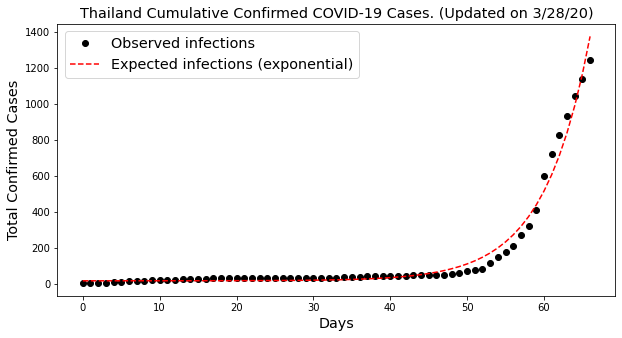



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1203
	Confirmed cases on 3/21/20 	 392
	Ratio: 3.07
	Weekly increase: 206.9 %
	Daily increase: 17.4 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9971409014075855
	Doubling Time (during middle of growth):  4.74 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.988321311912114
	Doubling Time (represents overall growth):  4.61 (± 0.52 ) days


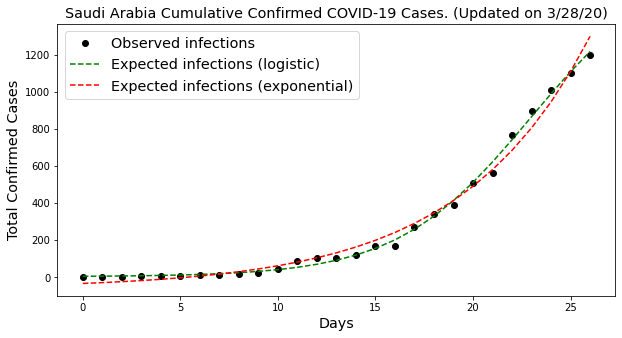



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1187
	Confirmed cases on 3/21/20 	 240
	Ratio: 4.95
	Weekly increase: 394.6 %
	Daily increase: 25.7 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.9938663364978613
	Doubling Time (during middle of growth):  3.53 (± 0.66 ) days

** Based on Exponential Fit **

	R^2: 0.9854463982868961
	Doubling Time (represents overall growth):  3.22 (± 0.4 ) days


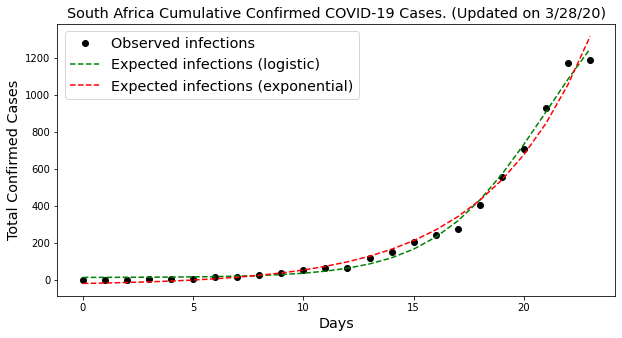



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1167
	Confirmed cases on 3/21/20 	 523
	Ratio: 2.23
	Weekly increase: 123.1 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9964083559119726
	Doubling Time (during middle of growth):  6.73 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.9882614679660118
	Doubling Time (represents overall growth):  5.45 (± 0.33 ) days


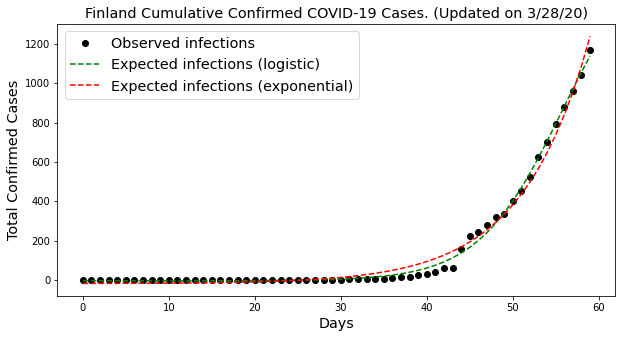



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1155
	Confirmed cases on 3/21/20 	 450
	Ratio: 2.57
	Weekly increase: 156.7 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9985727192790184
	Doubling Time (during middle of growth):  6.3 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.9951278391338713
	Doubling Time (represents overall growth):  5.02 (± 0.38 ) days


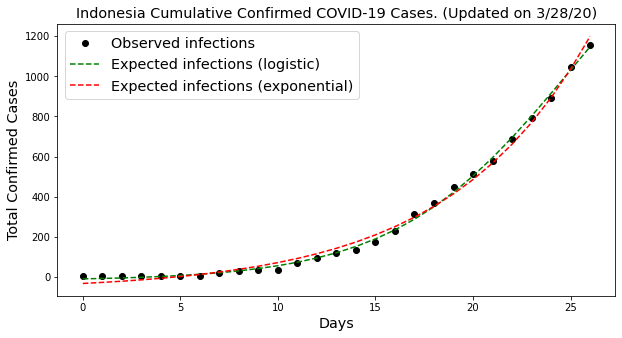



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1075
	Confirmed cases on 3/21/20 	 307
	Ratio: 3.5
	Weekly increase: 250.2 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.9947806051306758
	Doubling Time (represents overall growth):  4.09 (± 0.16 ) days


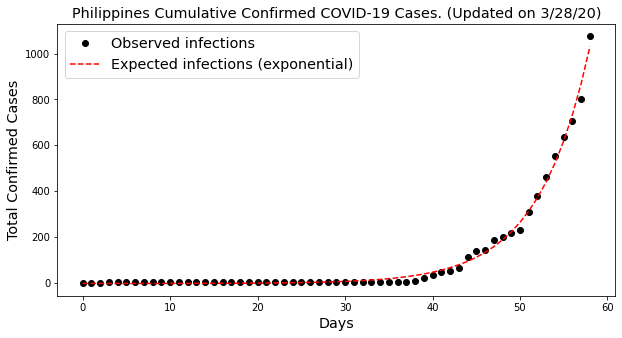



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 1061
	Confirmed cases on 3/21/20 	 530
	Ratio: 2.0
	Weekly increase: 100.2 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.99439236856099
	Doubling Time (during middle of growth):  8.97 (± 1.86 ) days

** Based on Exponential Fit **

	R^2: 0.9906542611260216
	Doubling Time (represents overall growth):  7.59 (± 0.86 ) days


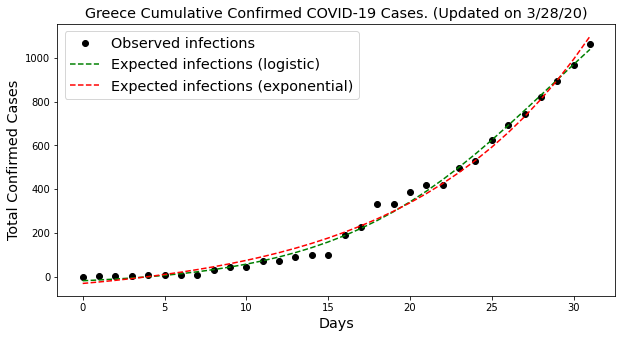



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 987
	Confirmed cases on 3/21/20 	 330
	Ratio: 2.99
	Weekly increase: 199.1 %
	Daily increase: 16.9 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9961612973403253
	Doubling Time (represents overall growth):  4.16 (± 0.14 ) days


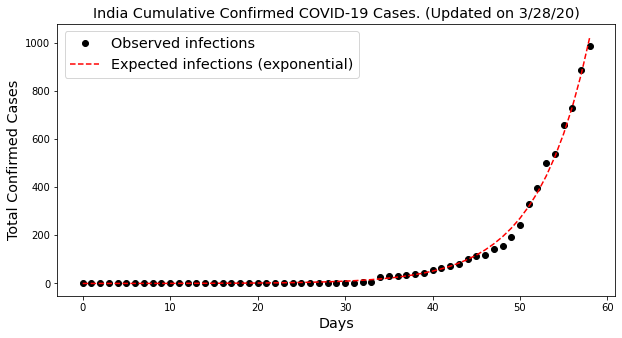



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 963
	Confirmed cases on 3/21/20 	 473
	Ratio: 2.04
	Weekly increase: 103.6 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9972719144513461
	Doubling Time (during middle of growth):  6.69 (± 0.83 ) days

** Based on Exponential Fit **

	R^2: 0.9919035383482226
	Doubling Time (represents overall growth):  6.34 (± 0.64 ) days


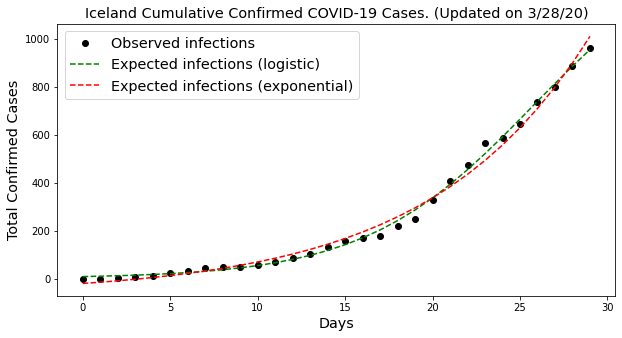



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 802
	Confirmed cases on 3/21/20 	 432
	Ratio: 1.86
	Weekly increase: 85.6 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9891982589831146
	Doubling Time (during middle of growth):  14.3 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.9891982592554813
	Doubling Time (represents overall growth):  7.15 (± 0.41 ) days


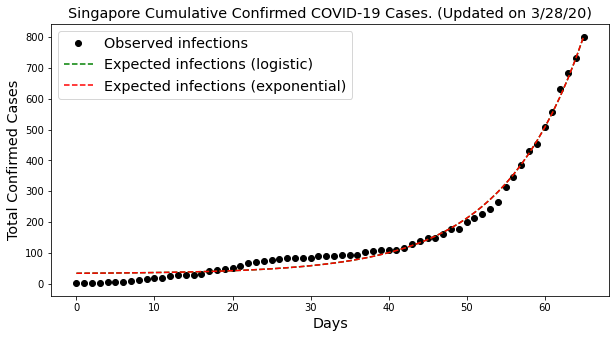



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 786
	Confirmed cases on 3/21/20 	 200
	Ratio: 3.93
	Weekly increase: 293.0 %
	Daily increase: 21.6 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9925390220018842
	Doubling Time (during middle of growth):  6.2 (± 2.55 ) days

** Based on Exponential Fit **

	R^2: 0.991969602814266
	Doubling Time (represents overall growth):  3.99 (± 0.52 ) days


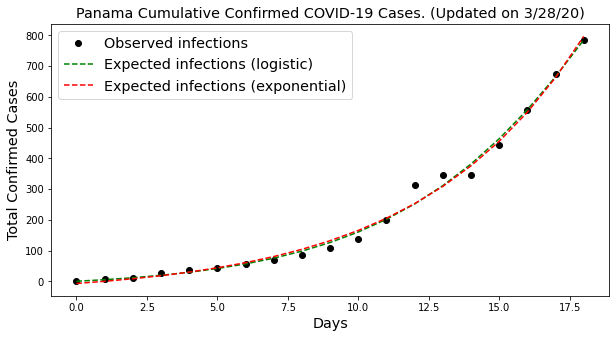



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 719
	Confirmed cases on 3/21/20 	 112
	Ratio: 6.42
	Weekly increase: 542.0 %
	Daily increase: 30.4 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.9965310898805778
	Doubling Time (during middle of growth):  3.6 (± 0.46 ) days

** Based on Exponential Fit **

	R^2: 0.9890805330911032
	Doubling Time (represents overall growth):  2.96 (± 0.27 ) days


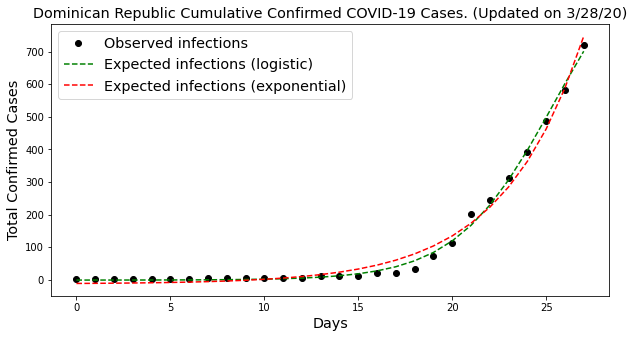



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 717
	Confirmed cases on 3/21/20 	 203
	Ratio: 3.53
	Weekly increase: 253.2 %
	Daily increase: 19.8 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.9960851671690848
	Doubling Time (during middle of growth):  6.0 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9947238897476244
	Doubling Time (represents overall growth):  3.83 (± 0.24 ) days


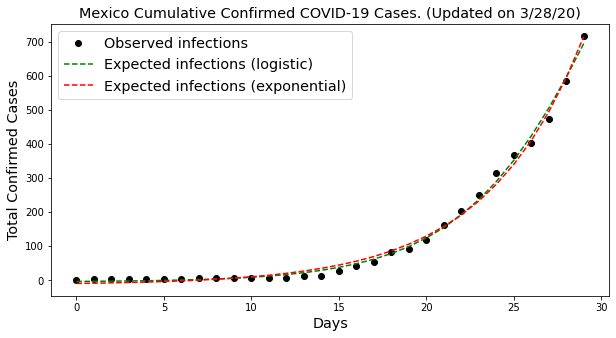



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.996150093877406
	Doubling Time (during middle of growth):  2.8 (± 0.25 ) days


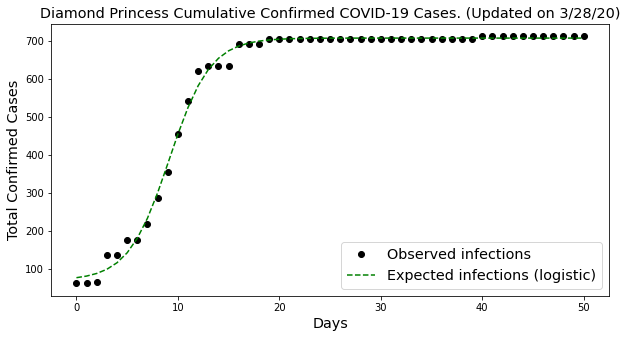



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 690
	Confirmed cases on 3/21/20 	 158
	Ratio: 4.37
	Weekly increase: 336.7 %
	Daily increase: 23.4 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.9943353634927652
	Doubling Time (during middle of growth):  4.96 (± 0.95 ) days

** Based on Exponential Fit **

	R^2: 0.9908313992630418
	Doubling Time (represents overall growth):  3.8 (± 0.37 ) days


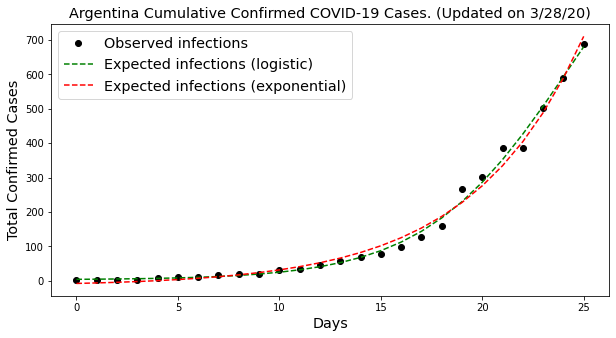



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 684
	Confirmed cases on 3/21/20 	 383
	Ratio: 1.79
	Weekly increase: 78.6 %
	Daily increase: 8.6 % per day
	Doubling Time (represents recent growth): 8.4 days

** Based on Logistic Fit**

	R^2: 0.990678976393828
	Doubling Time (during middle of growth):  22.41 (± 43.53 ) days

** Based on Exponential Fit **

	R^2: 0.9741492758839193
	Doubling Time (represents overall growth):  7.68 (± 2.16 ) days


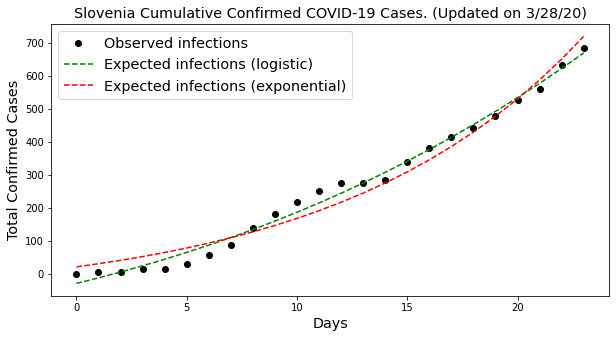



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 671
	Confirmed cases on 3/21/20 	 318
	Ratio: 2.11
	Weekly increase: 111.0 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9930242607405396
	Doubling Time (during middle of growth):  5.48 (± 1.29 ) days

** Based on Exponential Fit **

	R^2: 0.9846850225401261
	Doubling Time (represents overall growth):  6.22 (± 1.19 ) days


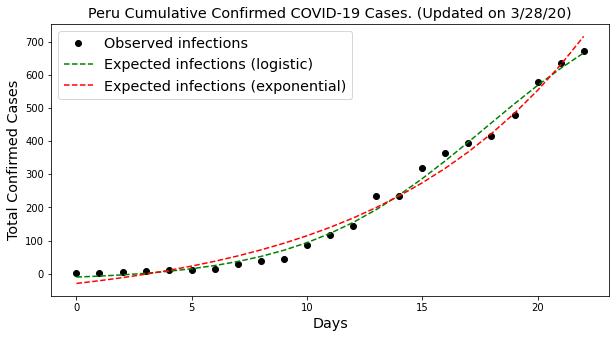



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 659
	Confirmed cases on 3/21/20 	 171
	Ratio: 3.85
	Weekly increase: 285.4 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9877167890456088
	Doubling Time (during middle of growth):  7.77 (± 1.5 ) days

** Based on Exponential Fit **

	R^2: 0.9877167895960053
	Doubling Time (represents overall growth):  3.89 (± 0.5 ) days


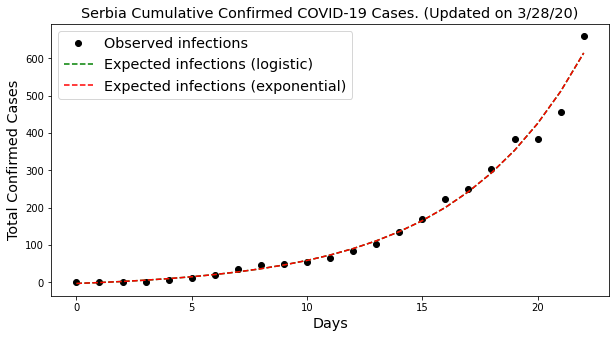



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 657
	Confirmed cases on 3/21/20 	 206
	Ratio: 3.19
	Weekly increase: 218.9 %
	Daily increase: 18.0 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9982805627609863
	Doubling Time (during middle of growth):  4.36 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9893558255114824
	Doubling Time (represents overall growth):  3.91 (± 0.33 ) days


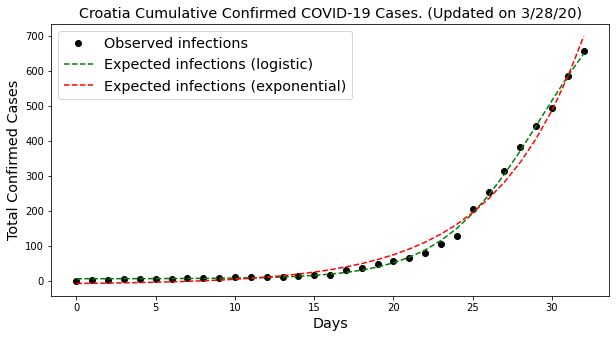



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 645
	Confirmed cases on 3/21/20 	 306
	Ratio: 2.11
	Weekly increase: 110.8 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9729193177801442
	Doubling Time (during middle of growth):  10.45 (± 6.13 ) days

** Based on Exponential Fit **

	R^2: 0.9719585974837551
	Doubling Time (represents overall growth):  7.29 (± 1.45 ) days


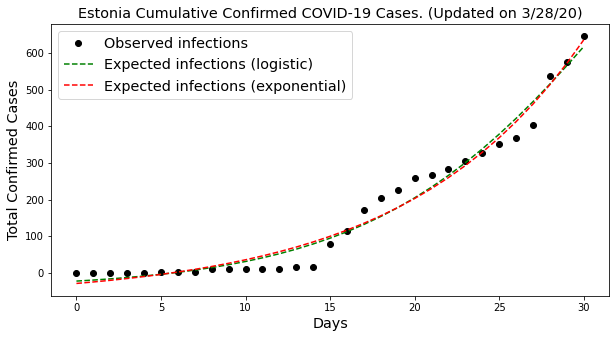



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 608
	Confirmed cases on 3/21/20 	 196
	Ratio: 3.1
	Weekly increase: 210.2 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9963111885580153
	Doubling Time (during middle of growth):  3.95 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.9834036270014753
	Doubling Time (represents overall growth):  4.58 (± 0.74 ) days


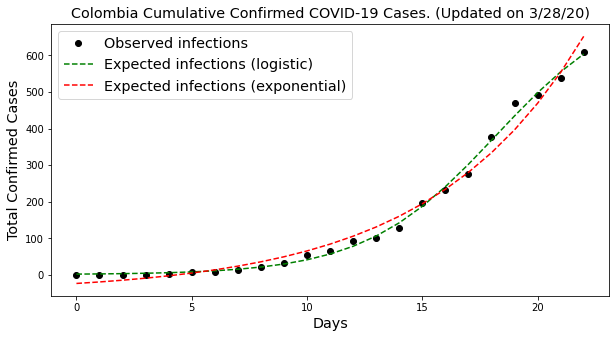



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 590
	Confirmed cases on 3/21/20 	 481
	Ratio: 1.23
	Weekly increase: 22.7 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.8 days

** Based on Logistic Fit**

	R^2: 0.9737262933866982
	Doubling Time (during middle of growth):  2.89 (± 0.86 ) days


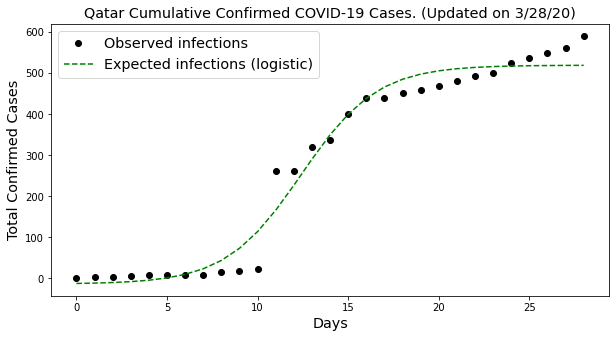



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 576
	Confirmed cases on 3/21/20 	 294
	Ratio: 1.96
	Weekly increase: 95.9 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9968489952896546
	Doubling Time (during middle of growth):  7.35 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.9888541779635727
	Doubling Time (represents overall growth):  6.45 (± 0.51 ) days


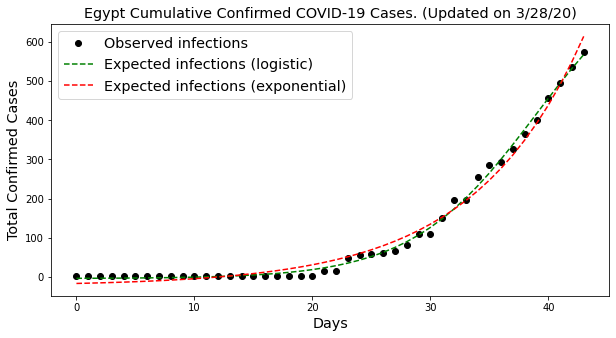



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 506
	Confirmed cases on 3/21/20 	 214
	Ratio: 2.36
	Weekly increase: 136.4 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9957407989857188
	Doubling Time (during middle of growth):  12.61 (± 1.25 ) days

** Based on Exponential Fit **

	R^2: 0.995740799468354
	Doubling Time (represents overall growth):  6.31 (± 0.4 ) days


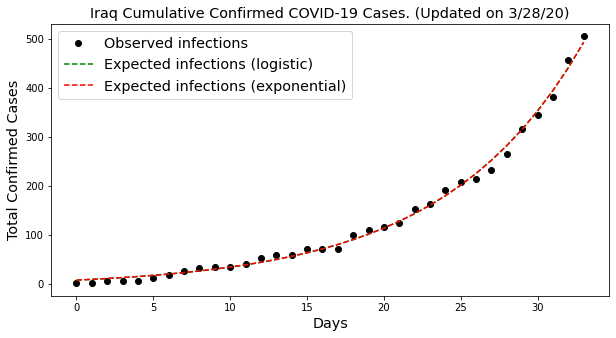



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 476
	Confirmed cases on 3/21/20 	 305
	Ratio: 1.56
	Weekly increase: 56.1 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.986416691333418
	Doubling Time (during middle of growth):  14.38 (± 7.22 ) days

** Based on Exponential Fit **

	R^2: 0.9849342973337574
	Doubling Time (represents overall growth):  12.81 (± 2.54 ) days


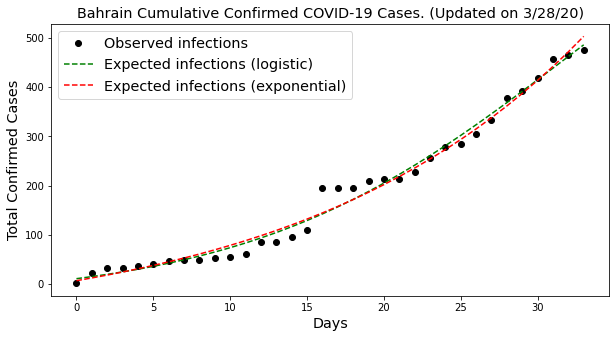



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 468
	Confirmed cases on 3/21/20 	 153
	Ratio: 3.06
	Weekly increase: 205.9 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.984488927638081
	Doubling Time (represents overall growth):  4.93 (± 0.34 ) days


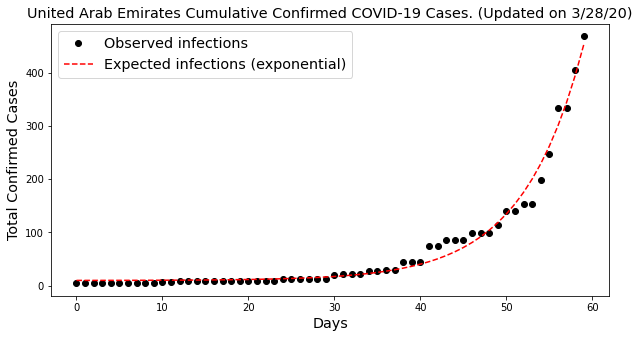



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 454
	Confirmed cases on 3/21/20 	 139
	Ratio: 3.27
	Weekly increase: 226.6 %
	Daily increase: 18.4 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9958151912003396
	Doubling Time (during middle of growth):  4.96 (± 0.64 ) days

** Based on Exponential Fit **

	R^2: 0.9899986986821454
	Doubling Time (represents overall growth):  4.16 (± 0.35 ) days


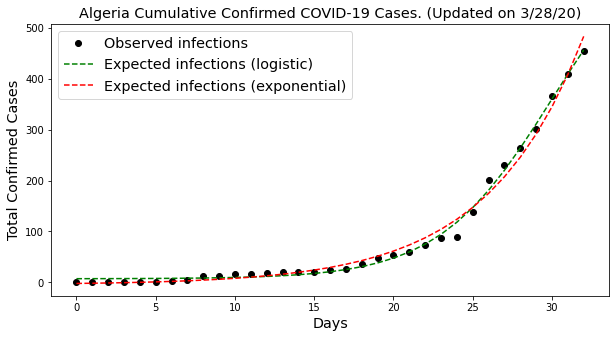



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 451
	Confirmed cases on 3/21/20 	 52
	Ratio: 8.67
	Weekly increase: 767.3 %
	Daily increase: 36.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.9952894586949804
	Doubling Time (represents overall growth):  2.48 (± 0.14 ) days


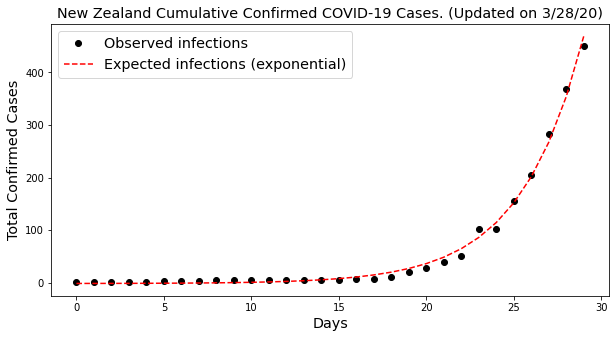



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 412
	Confirmed cases on 3/21/20 	 187
	Ratio: 2.2
	Weekly increase: 120.3 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9950198477812544
	Doubling Time (during middle of growth):  8.5 (± 1.35 ) days

** Based on Exponential Fit **

	R^2: 0.9917867829592353
	Doubling Time (represents overall growth):  6.61 (± 0.54 ) days


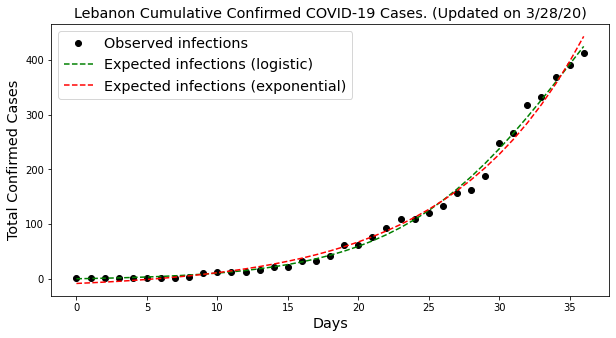



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 407
	Confirmed cases on 3/21/20 	 160
	Ratio: 2.54
	Weekly increase: 154.4 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9899664299732573
	Doubling Time (during middle of growth):  5.52 (± 1.27 ) days

** Based on Exponential Fit **

	R^2: 0.9818429213359599
	Doubling Time (represents overall growth):  5.42 (± 0.81 ) days


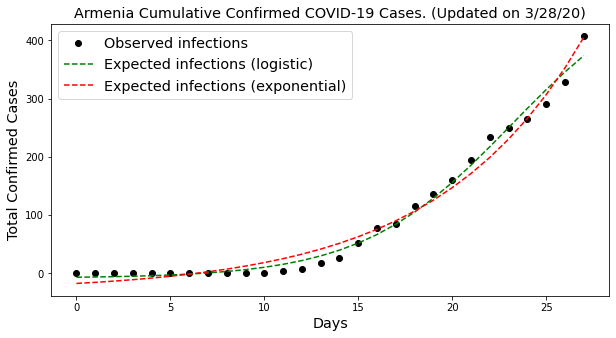



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 402
	Confirmed cases on 3/21/20 	 96
	Ratio: 4.19
	Weekly increase: 318.8 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9987844229609099
	Doubling Time (during middle of growth):  6.01 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9985058824030819
	Doubling Time (represents overall growth):  3.38 (± 0.12 ) days


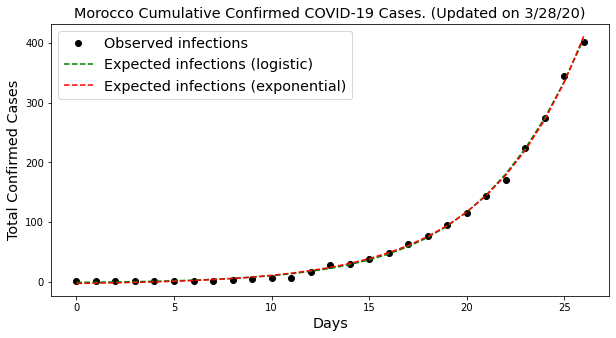



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 394
	Confirmed cases on 3/21/20 	 83
	Ratio: 4.75
	Weekly increase: 374.7 %
	Daily increase: 24.9 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9971001328645954
	Doubling Time (during middle of growth):  3.22 (± 0.33 ) days

** Based on Exponential Fit **

	R^2: 0.9790793850313827
	Doubling Time (represents overall growth):  3.51 (± 0.44 ) days


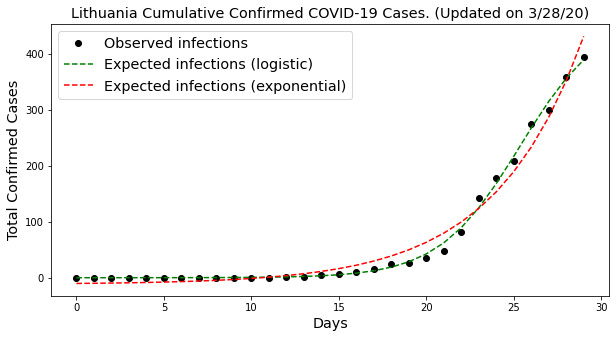



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 356
	Confirmed cases on 3/21/20 	 47
	Ratio: 7.57
	Weekly increase: 657.4 %
	Daily increase: 33.5 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.9908922731080854
	Doubling Time (represents overall growth):  2.28 (± 0.19 ) days


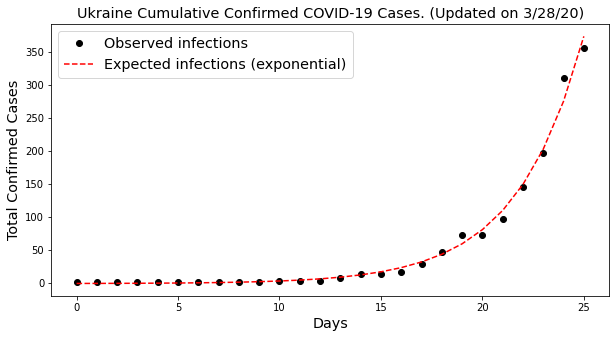



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 343
	Confirmed cases on 3/21/20 	 103
	Ratio: 3.33
	Weekly increase: 233.0 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.9992607678189086
	Doubling Time (during middle of growth):  6.02 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9971820402400012
	Doubling Time (represents overall growth):  4.39 (± 0.26 ) days


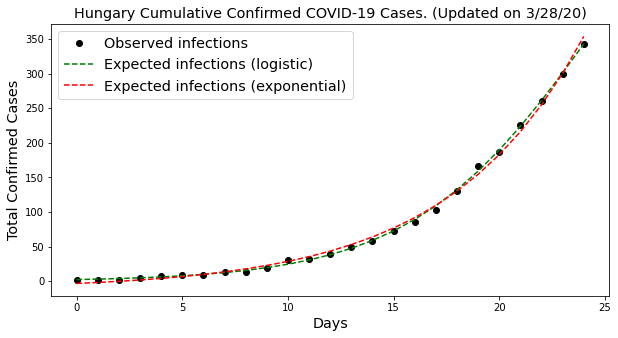



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 331
	Confirmed cases on 3/21/20 	 163
	Ratio: 2.03
	Weekly increase: 103.1 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9947970075136496
	Doubling Time (during middle of growth):  6.67 (± 1.87 ) days

** Based on Exponential Fit **

	R^2: 0.9909721741011961
	Doubling Time (represents overall growth):  8.44 (± 1.8 ) days


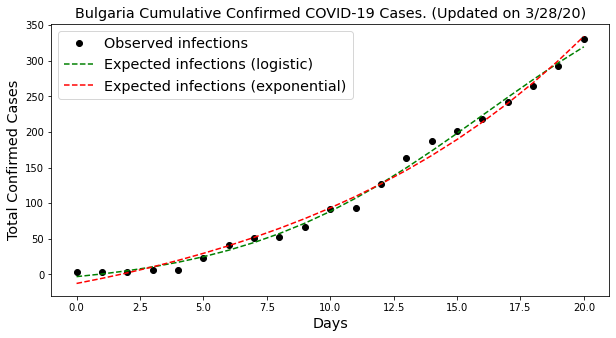



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 308
	Confirmed cases on 3/21/20 	 88
	Ratio: 3.5
	Weekly increase: 250.0 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9945595774927476
	Doubling Time (during middle of growth):  4.91 (± 0.87 ) days

** Based on Exponential Fit **

	R^2: 0.9889700303507195
	Doubling Time (represents overall growth):  3.93 (± 0.41 ) days


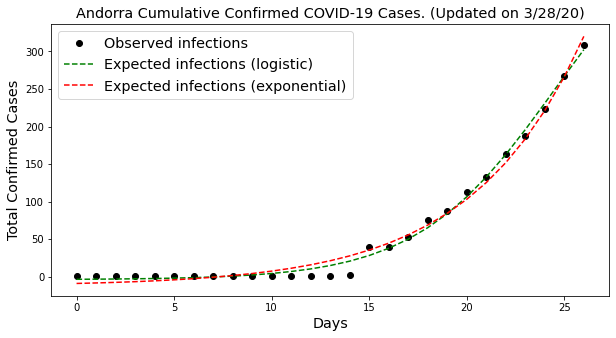



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 305
	Confirmed cases on 3/21/20 	 124
	Ratio: 2.46
	Weekly increase: 146.0 %
	Daily increase: 13.7 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9980116337271708
	Doubling Time (during middle of growth):  5.47 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9899526403008546
	Doubling Time (represents overall growth):  5.44 (± 0.63 ) days


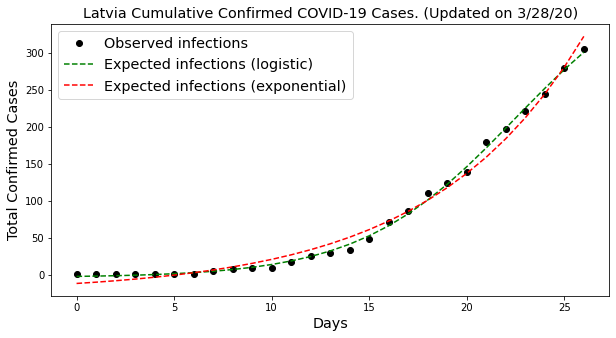



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 295
	Confirmed cases on 3/21/20 	 117
	Ratio: 2.52
	Weekly increase: 152.1 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.99759244573066
	Doubling Time (during middle of growth):  5.69 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.9935016107559276
	Doubling Time (represents overall growth):  5.21 (± 0.57 ) days


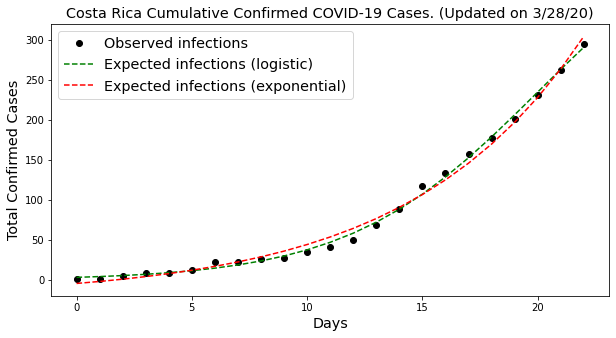



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 292
	Confirmed cases on 3/21/20 	 178
	Ratio: 1.64
	Weekly increase: 64.0 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9893221101065508
	Doubling Time (during middle of growth):  6.53 (± 2.16 ) days

** Based on Exponential Fit **

	R^2: 0.9824343504949208
	Doubling Time (represents overall growth):  10.03 (± 3.06 ) days


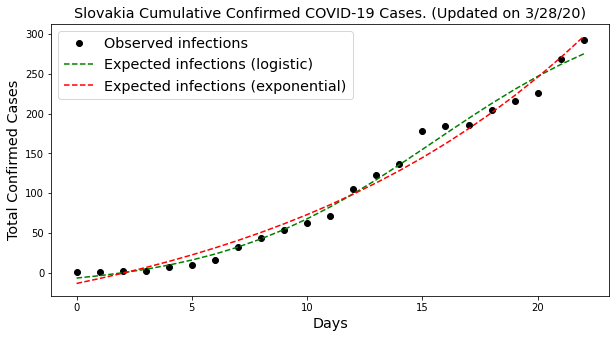



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 283
	Confirmed cases on 3/21/20 	 153
	Ratio: 1.85
	Weekly increase: 85.0 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Exponential Fit **

	R^2: 0.9793427567028175
	Doubling Time (represents overall growth):  6.05 (± 0.46 ) days


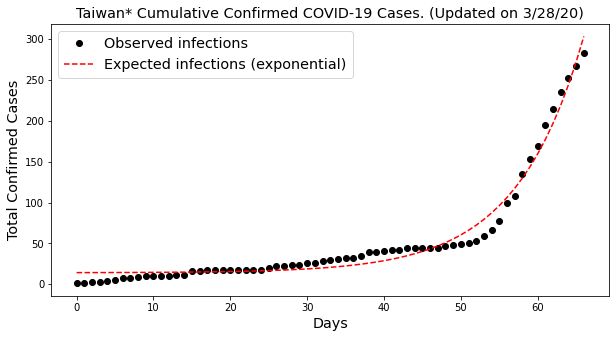



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 278
	Confirmed cases on 3/21/20 	 60
	Ratio: 4.63
	Weekly increase: 363.3 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9948465863381559
	Doubling Time (during middle of growth):  5.11 (± 1.04 ) days

** Based on Exponential Fit **

	R^2: 0.9936817161645709
	Doubling Time (represents overall growth):  3.31 (± 0.26 ) days


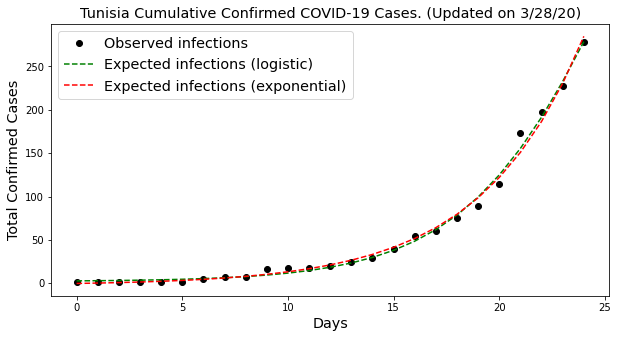



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 274
	Confirmed cases on 3/21/20 	 110
	Ratio: 2.49
	Weekly increase: 149.1 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9861049483188656
	Doubling Time (during middle of growth):  11.17 (± 23.63 ) days

** Based on Exponential Fit **

	R^2: 0.972475978439486
	Doubling Time (represents overall growth):  7.35 (± 4.1 ) days


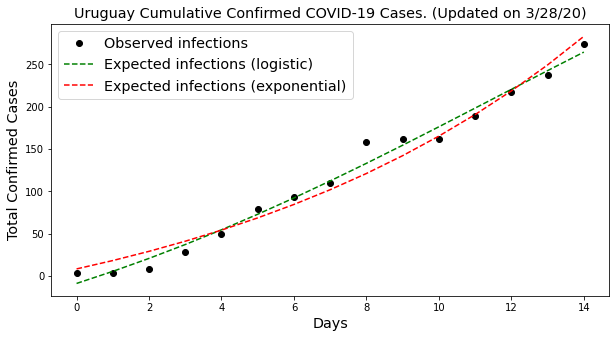



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 258
	Confirmed cases on 3/21/20 	 93
	Ratio: 2.77
	Weekly increase: 177.4 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9932093272613938
	Doubling Time (during middle of growth):  5.11 (± 1.1 ) days

** Based on Exponential Fit **

	R^2: 0.9859904666375298
	Doubling Time (represents overall growth):  5.17 (± 0.79 ) days


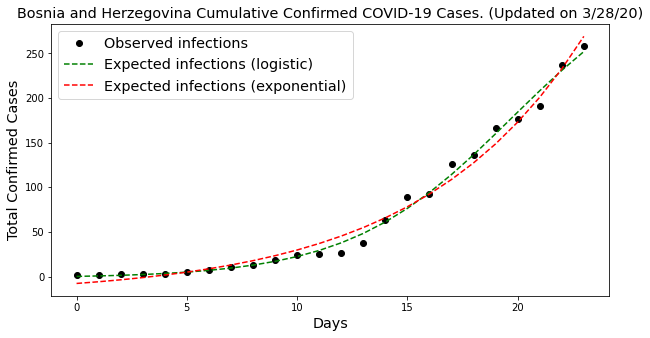



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 246
	Confirmed cases on 3/21/20 	 85
	Ratio: 2.89
	Weekly increase: 189.4 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9931914136597354
	Doubling Time (during middle of growth):  4.87 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9822181547266036
	Doubling Time (represents overall growth):  4.91 (± 0.75 ) days


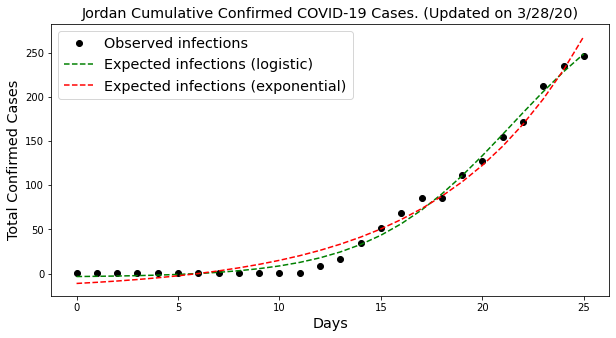



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 241
	Confirmed cases on 3/21/20 	 85
	Ratio: 2.84
	Weekly increase: 183.5 %
	Daily increase: 16.1 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9984700058527245
	Doubling Time (during middle of growth):  4.06 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.982153725970077
	Doubling Time (represents overall growth):  4.44 (± 0.52 ) days


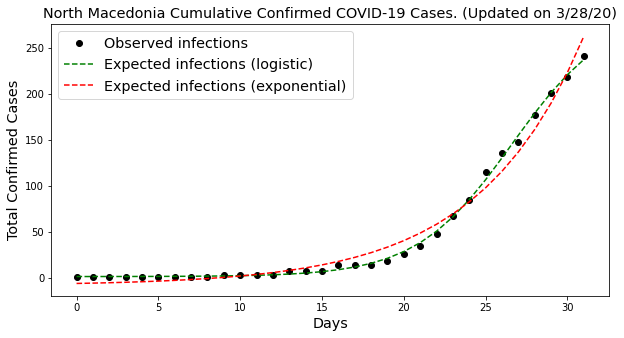



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 235
	Confirmed cases on 3/21/20 	 176
	Ratio: 1.34
	Weekly increase: 33.5 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.8 days

** Based on Logistic Fit**

	R^2: 0.9805491889642519
	Doubling Time (during middle of growth):  11.82 (± 5.41 ) days

** Based on Exponential Fit **

	R^2: 0.9786060805207486
	Doubling Time (represents overall growth):  14.72 (± 3.94 ) days


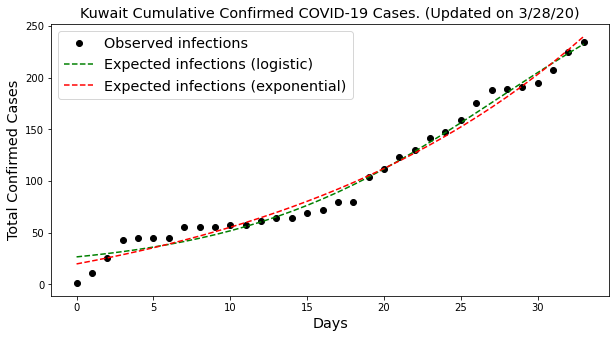



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 231
	Confirmed cases on 3/21/20 	 80
	Ratio: 2.89
	Weekly increase: 188.8 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9976043249237591
	Doubling Time (during middle of growth):  6.52 (± 1.3 ) days

** Based on Exponential Fit **

	R^2: 0.9960657857101141
	Doubling Time (represents overall growth):  4.96 (± 0.46 ) days


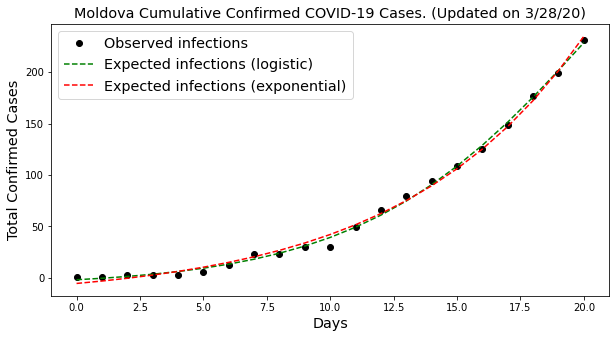



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 228
	Confirmed cases on 3/21/20 	 53
	Ratio: 4.3
	Weekly increase: 330.2 %
	Daily increase: 23.2 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.9556531697214985
	Doubling Time (during middle of growth):  4.51 (± 1.54 ) days

** Based on Exponential Fit **

	R^2: 0.9556531716738268
	Doubling Time (represents overall growth):  2.26 (± 0.64 ) days


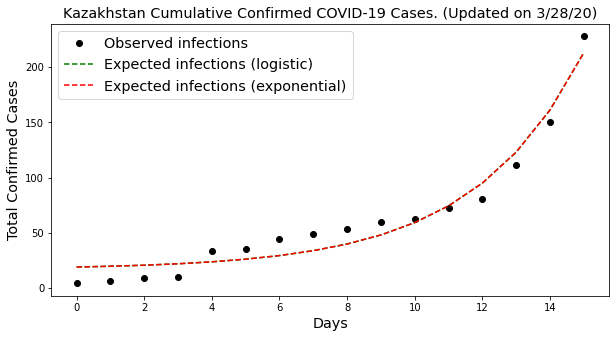



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 224
	Confirmed cases on 3/21/20 	 144
	Ratio: 1.56
	Weekly increase: 55.6 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9940319157409273
	Doubling Time (during middle of growth):  10.96 (± 2.93 ) days

** Based on Exponential Fit **

	R^2: 0.990312415573757
	Doubling Time (represents overall growth):  15.68 (± 3.41 ) days


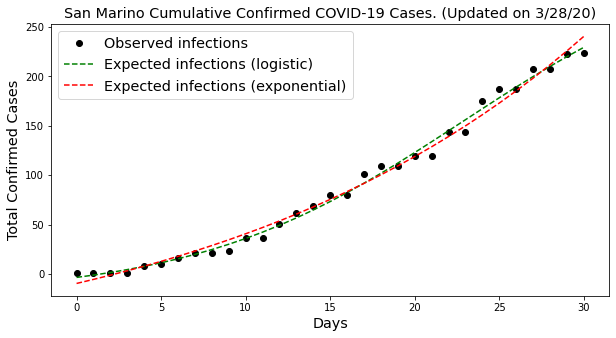



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 207
	Confirmed cases on 3/21/20 	 64
	Ratio: 3.23
	Weekly increase: 223.4 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9962582136113665
	Doubling Time (during middle of growth):  4.28 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.9883760398237369
	Doubling Time (represents overall growth):  4.76 (± 0.84 ) days


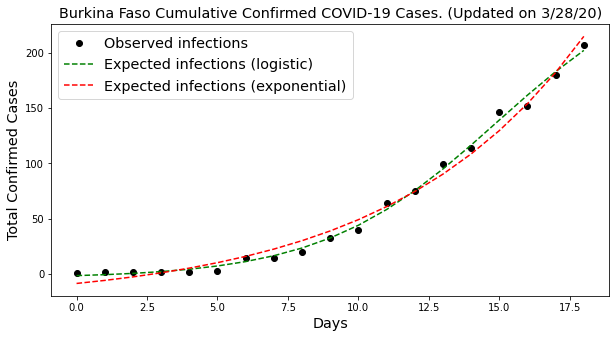



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 197
	Confirmed cases on 3/21/20 	 76
	Ratio: 2.59
	Weekly increase: 159.2 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9867722218914906
	Doubling Time (during middle of growth):  12.58 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.9867722221465498
	Doubling Time (represents overall growth):  6.29 (± 1.36 ) days


/Users/othmanerifki/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


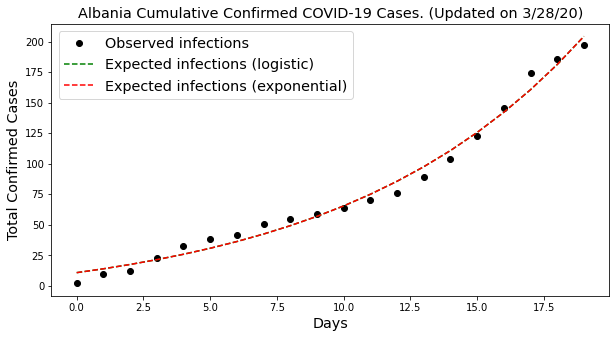



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 182
	Confirmed cases on 3/21/20 	 53
	Ratio: 3.43
	Weekly increase: 243.4 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9921680197287827
	Doubling Time (during middle of growth):  7.39 (± inf ) days

** Based on Exponential Fit **

	R^2: 0.9921680204309623
	Doubling Time (represents overall growth):  3.69 (± 0.3 ) days


/Users/othmanerifki/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


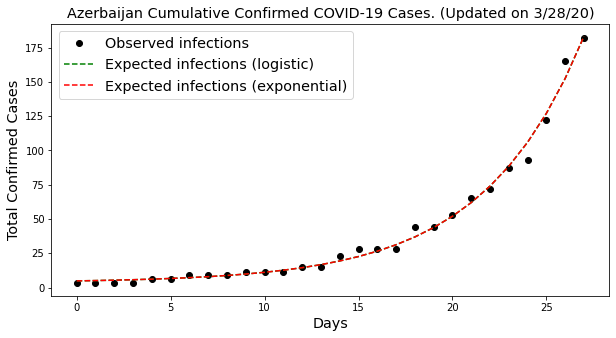



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 179
	Confirmed cases on 3/21/20 	 84
	Ratio: 2.13
	Weekly increase: 113.1 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9964190172292833
	Doubling Time (during middle of growth):  8.16 (± 2.7 ) days

** Based on Exponential Fit **

	R^2: 0.9947115614892641
	Doubling Time (represents overall growth):  9.74 (± 1.93 ) days


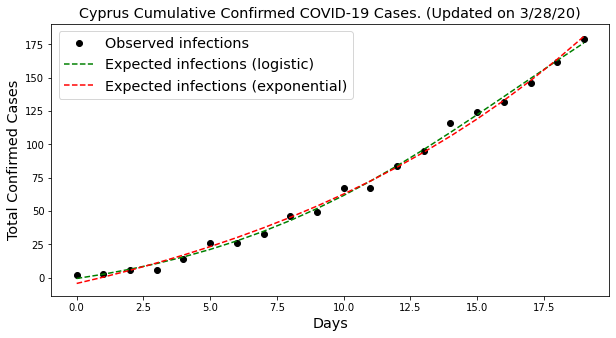



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 174
	Confirmed cases on 3/21/20 	 94
	Ratio: 1.85
	Weekly increase: 85.1 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Exponential Fit **

	R^2: 0.9867842730272606
	Doubling Time (represents overall growth):  7.01 (± 0.44 ) days


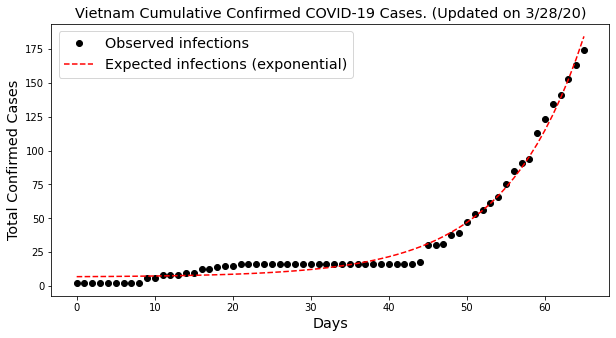



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 152
	Confirmed cases on 3/21/20 	 52
	Ratio: 2.92
	Weekly increase: 192.3 %
	Daily increase: 16.6 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.98916824600176
	Doubling Time (during middle of growth):  8.56 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.9891682462359457
	Doubling Time (represents overall growth):  4.28 (± 0.36 ) days


/Users/othmanerifki/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


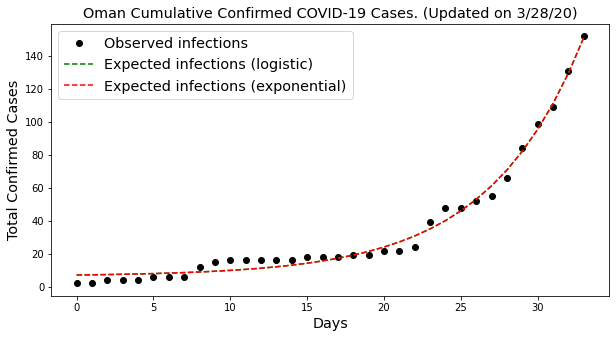



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 149
	Confirmed cases on 3/21/20 	 73
	Ratio: 2.04
	Weekly increase: 104.1 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9973120093703987
	Doubling Time (during middle of growth):  4.68 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9819623021880349
	Doubling Time (represents overall growth):  8.81 (± 2.59 ) days


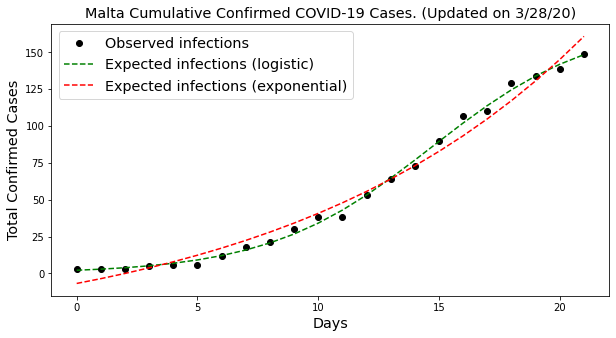



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 141
	Confirmed cases on 3/21/20 	 19
	Ratio: 7.42
	Weekly increase: 642.1 %
	Daily increase: 33.2 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.9923096635272574
	Doubling Time (during middle of growth):  1.17 (± 0.29 ) days


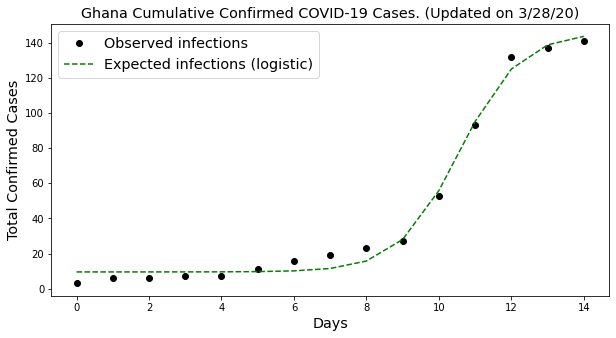



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 130
	Confirmed cases on 3/21/20 	 47
	Ratio: 2.77
	Weekly increase: 176.6 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9930823962193039
	Doubling Time (during middle of growth):  5.25 (± 1.02 ) days

** Based on Exponential Fit **

	R^2: 0.9844615962538839
	Doubling Time (represents overall growth):  5.33 (± 0.76 ) days


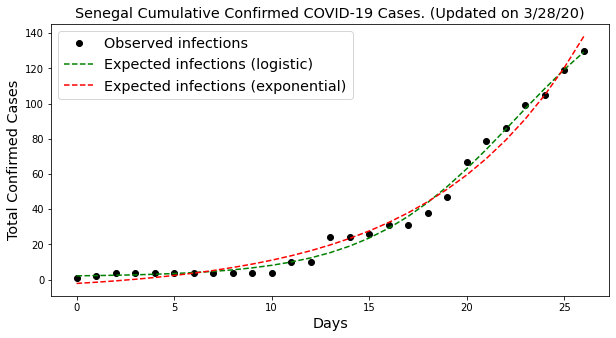



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 120
	Confirmed cases on 3/21/20 	 83
	Ratio: 1.45
	Weekly increase: 44.6 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.9888473672826584
	Doubling Time (during middle of growth):  28.01 (± 144.02 ) days


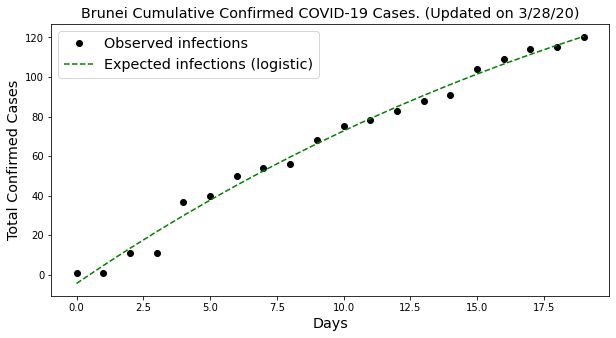



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 119
	Confirmed cases on 3/21/20 	 70
	Ratio: 1.7
	Weekly increase: 70.0 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9856243776356012
	Doubling Time (during middle of growth):  85.89 (± 9880.45 ) days

** Based on Exponential Fit **

	R^2: 0.9740123036497063
	Doubling Time (represents overall growth):  12.68 (± 11.45 ) days


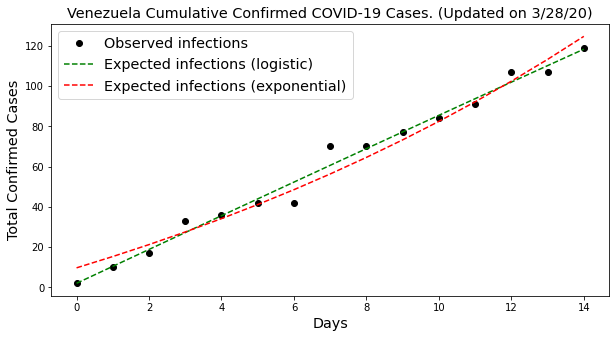



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 119
	Confirmed cases on 3/21/20 	 21
	Ratio: 5.67
	Weekly increase: 466.7 %
	Daily increase: 28.1 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9851594662532221
	Doubling Time (during middle of growth):  6.21 (± 2.23 ) days

** Based on Exponential Fit **

	R^2: 0.9851594665538552
	Doubling Time (represents overall growth):  3.1 (± 0.55 ) days


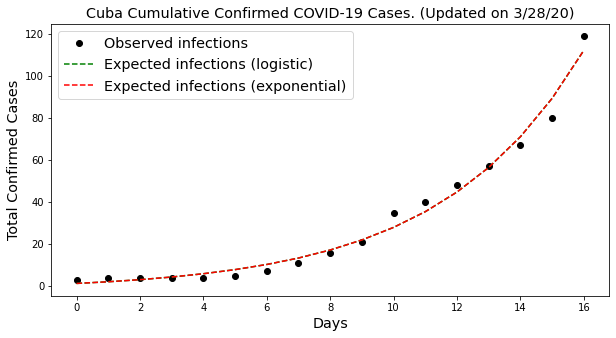



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 113
	Confirmed cases on 3/21/20 	 77
	Ratio: 1.47
	Weekly increase: 46.8 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9967610402237996
	Doubling Time (during middle of growth):  3.21 (± 0.23 ) days


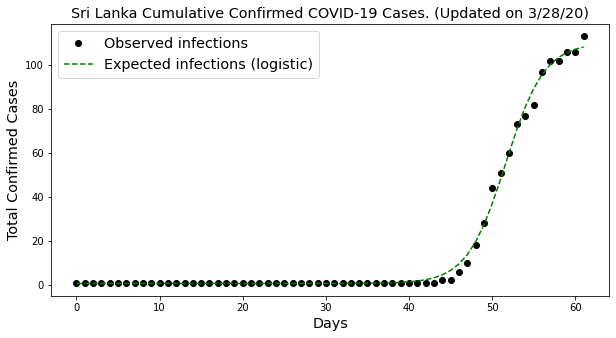



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 110
	Confirmed cases on 3/21/20 	 24
	Ratio: 4.58
	Weekly increase: 358.3 %
	Daily increase: 24.3 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9764845932566982
	Doubling Time (during middle of growth):  5.17 (± 1.63 ) days

** Based on Exponential Fit **

	R^2: 0.9725031826429534
	Doubling Time (represents overall growth):  4.03 (± 0.54 ) days


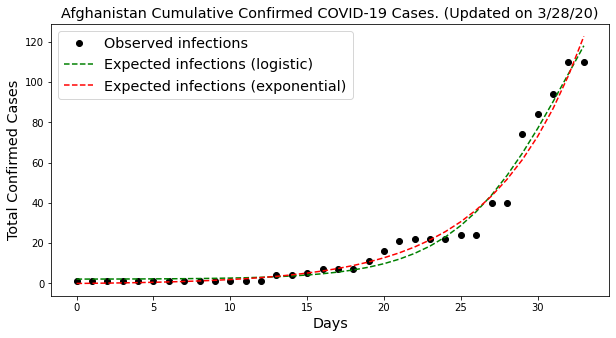



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 104
	Confirmed cases on 3/21/20 	 43
	Ratio: 2.42
	Weekly increase: 141.9 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9806406535559176
	Doubling Time (during middle of growth):  14.59 (± inf ) days

** Based on Exponential Fit **

	R^2: 0.9806406567957628
	Doubling Time (represents overall growth):  7.3 (± 3.72 ) days


/Users/othmanerifki/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


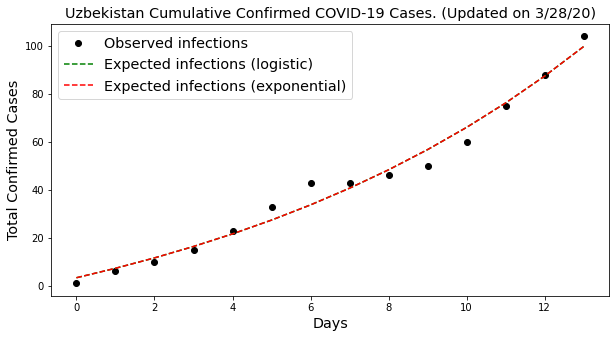



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 102
	Confirmed cases on 3/21/20 	 14
	Ratio: 7.29
	Weekly increase: 628.6 %
	Daily increase: 32.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.9808828826552579
	Doubling Time (during middle of growth):  3.73 (± 3.52 ) days

** Based on Exponential Fit **

	R^2: 0.9778216835268222
	Doubling Time (represents overall growth):  4.6 (± 2.43 ) days


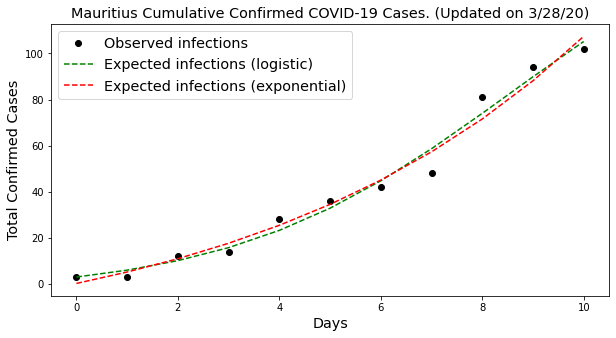



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 101
	Confirmed cases on 3/21/20 	 14
	Ratio: 7.21
	Weekly increase: 621.4 %
	Daily increase: 32.6 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.9866473624774945
	Doubling Time (during middle of growth):  1.04 (± 0.33 ) days


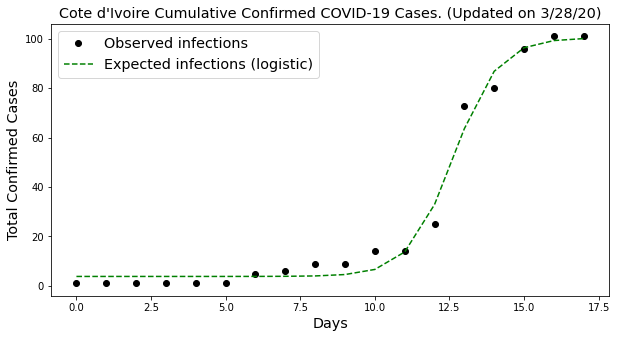

In [23]:
#plotCases(covid_confirmed, 'Country/Region', 'Switzerland')
mostrecentdate = dates[-1]
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]

topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
prediction_after_21days = []
countries = []
print('\n')



for c in topcountries[:]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

    

## Prediction for the next 3 weeks ## 